In [1]:
import numpy as np
import pickle
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


## **Importing the dataset from the local directory**

In [101]:
# Function to unpickle the dataset
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the propper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return (train_x, train_y), (test_x, test_y)

# Run the function with and include the folder where the data are
(X_train, y_train), (X_test, y_test) = unpickle_all_data(r"C:\Users\rohan\Desktop\PRML_Project\cifar-10-python\cifar-10-batches-py")



Handing file: data_batch_1
Handing file: data_batch_2
Handing file: data_batch_3
Handing file: data_batch_4
Handing file: data_batch_5
Handing file: test_batch


## **Data Preprocessing**

### LOADING THE DATASET

Reference of the dataset : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf  
Dataset and methodology followed is decribed in greater detail in the above cited link.


In [56]:
# we will load the cifar10 dataset from keras
# reference : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
# dataset and methodology followed is decribed in greater detail in the above cited link.
# from keras.datasets import cifar10

# (X_train, y_train),(X_test, y_test) = cifar10.load_data()


ABOUT THE DATASET -


*   The dataset has 50000 training samples and 10000 test samples
*   cifar10 implies 10 class labels (or target labels)
*   Each sample has the shape (32,32,3)
*   Pixels in 32X32 images are indexed in values of three channels of Red, Blue and Green



In [57]:
print(f'Shape of the training set (features): {X_train.shape}')
print(f'Shape of the training set (target): {y_train.shape}')
print(f'Shape of the test set (features): {X_test.shape}')
print(f'Shape of the test set (target): {y_test.shape}')


Shape of the training set (features): (50000, 32, 32, 3)
Shape of the training set (target): (50000,)
Shape of the test set (features): (10000, 32, 32, 3)
Shape of the test set (target): (10000,)


### Visualizing the image set

Text(0.5, 1.0, 'A single image')

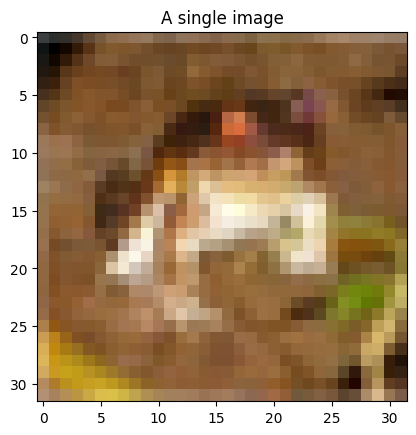

In [58]:
#plotting the first sample of the trainging set
plt.imshow(X_train[0])
plt.title('A single image')

In [59]:
print(y_train)

[6 9 9 ... 9 1 1]


The target set contains integer class labels representing one of the ten classes in the CIFAR-10 dataset.



In [60]:
# These are the classnames in the dataset in the order
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


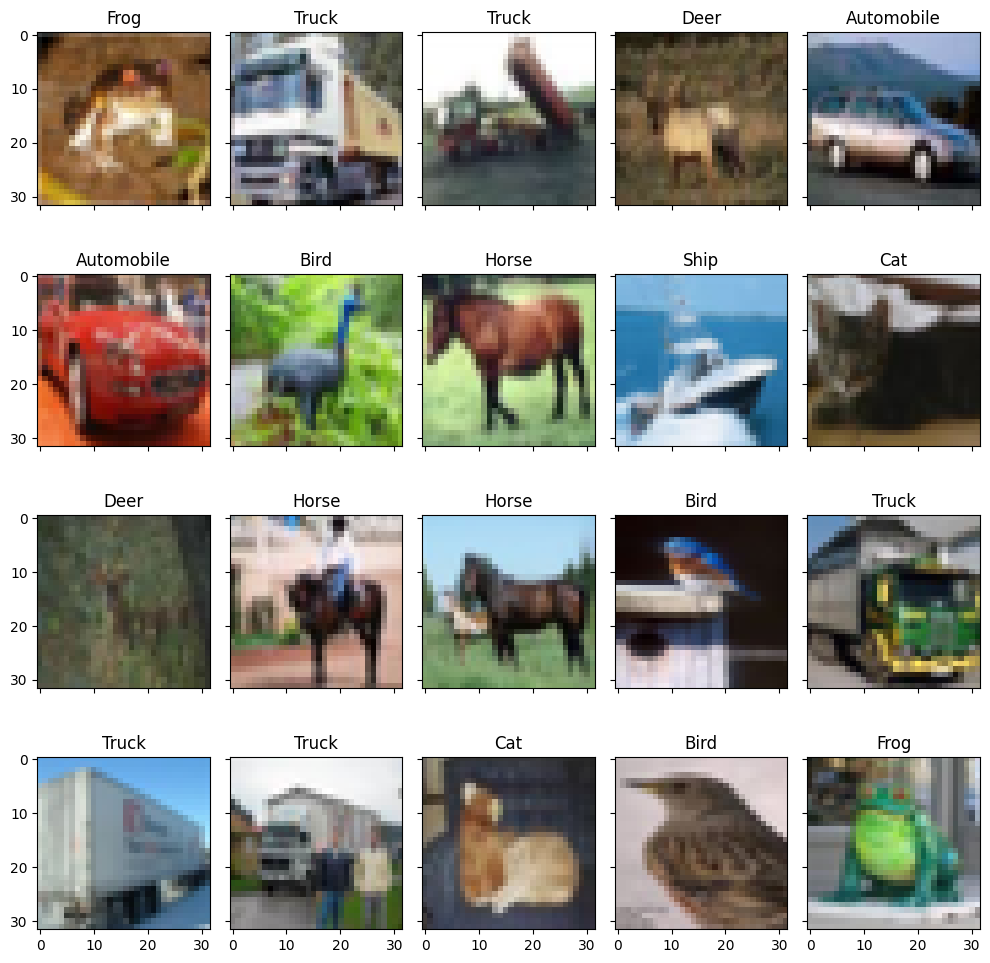

In [61]:
#making a subplot of first few images

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(X_train[i])
  ax.set_title(class_names[y_train[i]])
  # ax.set_title(class_names[y_train[i][0]])

plt.tight_layout()
plt.show()

Data Normalisation

In [62]:
# Flattening the features array
# Flattening is typically done as traditional ml models require input in 2-d format
# more on the 2-d format - each row represents a single sample (image) and each column represents a feature (pixel).
print(f"here is X_train's shape before Flattening \n{X_train.shape}")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"here is X_train's shape after Flattening \n{X_train_flat.shape}")
# As the pixel values in rgb channel of feature set range from 0-255 we are scaling it down to 0.0-1.0

min_value = np.min(X_train_flat)
max_value = np.max(X_train_flat)
# Perform min-max normalization
X_train_normalized = (X_train_flat - min_value) / (max_value - min_value)
X_test_normalized = (X_test_flat - min_value) / (max_value - min_value)

here is X_train's shape before Flattening 
(50000, 32, 32, 3)
here is X_train's shape after Flattening 
(50000, 3072)


In [11]:
# print(f'here is the y_train before Flattening : \n',y_train)
# print(f'here is the shape of y_train before Flattening : ',y_train.shape)


# # Flatten target labels
# y_train = np.ravel(y_train)
# print(f"\nhere is y_train after Flattening \n{y_train} \n and it's shape after Flattening\n{y_train.shape}")

# print('\nsimilar process is for y_test')
# y_test = np.ravel(y_test)


## **Testing some classical machine learning models**

### KNN

In [12]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train_normalized, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_normalized)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)


Accuracy of KNN: 0.3398
Precision of KNN: 0.4304261825528496
Recall of KNN: 0.3398
F1 Score of KNN: 0.3260170986061005


### Decision tree

In [13]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_normalized, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_normalized)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)


Accuracy of Decision Tree Classifier: 0.271
Precision of Decision Tree Classifier: 0.27107273834145645
Recall of Decision Tree Classifier: 0.271
F1 Score of Decision Tree Classifier: 0.2709371571716179


### Random forest classifier

In [14]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_normalized, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_normalized)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.469
Precision of Random Forest Classifier: 0.46488222624866976
Recall of Random Forest Classifier: 0.469
F1 Score of Random Forest Classifier: 0.4656768450982205


### Naive bayes classifier

In [15]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_normalized, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_normalized)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.2976
Precision of Naive Bayes Classifier: 0.31121406674181173
Recall of Naive Bayes Classifier: 0.2976
F1 Score of Naive Bayes Classifier: 0.27546278386551976


### SVM

In [106]:
# Train the SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train_normalized, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_normalized)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision",precision)


Accuracy: 0.5437
Recall: 0.5437
F1 Score: 0.5421178002126918
Precision 0.5425592446958152


### ANN

In [120]:
from tensorflow.keras.utils import to_categorical

# Convert target arrays to one-hot encoded format
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Define the model
simple_model = Sequential([
    Dense(8000, input_shape=(3072,), activation='relu'),
    Dense(5000, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
simple_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
simple_model_history = simple_model.fit(X_train_normalized, y_train_one_hot, batch_size=100, epochs=8, validation_data=(X_test_normalized, y_test_one_hot))


Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 212ms/step - accuracy: 0.2740 - loss: 1.9996 - val_accuracy: 0.3983 - val_loss: 1.7342
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 200ms/step - accuracy: 0.3960 - loss: 1.7228 - val_accuracy: 0.4064 - val_loss: 1.6917
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 214ms/step - accuracy: 0.4228 - loss: 1.6544 - val_accuracy: 0.4461 - val_loss: 1.6005
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 102s 203ms/step - accuracy: 0.4487 - loss: 1.5887 - val_accuracy: 0.4611 - val_loss: 1.5751
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 199ms/step - accuracy: 0.4579 - loss: 1.5477 - val_accuracy: 0.4613 - val_loss: 1.5410
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - accuracy: 0.4751 - loss: 1.5093 - val_accuracy: 0.4535 - val_loss: 1.5271
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 201ms/step - accuracy: 0.4868 - loss: 1.4774 - val_accuracy: 0.4712 - val_loss: 1.5042
Epoch 8/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - accuracy: 0.4962 - loss: 1.4

In [121]:
# Predict classes for the test set
y_pred = simple_model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to categorical labels
y_test_categorical = np.argmax(y_test_one_hot, axis=1)

# Calculate precision
precision = precision_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Calculate recall
recall = recall_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test_categorical, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision",precision)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Accuracy: 0.4765
Recall: 0.4765
F1 Score: 0.47214111727640573
Precision 0.48933854631427676


## LDA

In [17]:
# Apply LDA
lda = LinearDiscriminantAnalysis()  # Adjust the number of components as per requirement
X_train_lda = lda.fit_transform(X_train_normalized, y_train)
X_test_lda = lda.transform(X_test_normalized)
print(X_train_lda.shape)
# KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train_lda, y_train)
y_pred_knn = knn.predict(X_test_lda)

# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_lda, y_train)
y_pred_dt = dt.predict(X_test_lda)

# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_lda, y_train)
y_pred_rf = rf.predict(X_test_lda)

# Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train_lda, y_train)
y_pred_nb = nb.predict(X_test_lda)

# SVM
svm = SVC(kernel='rbf', gamma='scale', C=1.0)
svm.fit(X_train_lda, y_train)
y_pred_svm = svm.predict(X_test_lda)

# Evaluate models
print("K-Nearest Neighbors:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_knn, average='weighted'))

print("\nDecision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))

print("\nNaive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))

print("\nSVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))

(50000, 9)
K-Nearest Neighbors:
Accuracy: 0.3295
Precision: 0.334759002512748
Recall: 0.3295

Decision Tree:
Accuracy: 0.2789
Precision: 0.2788503985966943
Recall: 0.2789

Random Forest:
Accuracy: 0.3698
Precision: 0.3681441492176132
Recall: 0.3698

Naive Bayes:
Accuracy: 0.3659
Precision: 0.36613766941467
Recall: 0.3659

SVM:
Accuracy: 0.3737
Precision: 0.3730106493100517
Recall: 0.3737


## **Performing PCA**

In [107]:
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=0.95)  # retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

n_components_chosen = pca.n_components_
print("Number of components chosen:", n_components_chosen)
print(X_train_pca.shape)

Number of components chosen: 217
(50000, 217)


### KNN

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train_pca, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.3625
Precision of KNN: 0.4466677313172691
Recall of KNN: 0.3625
F1 Score of KNN: 0.354497969454903


### Decision Tree

In [20]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_pca, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_pca)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.2575
Precision of Decision Tree Classifier: 0.2578415673481506
Recall of Decision Tree Classifier: 0.2575
F1 Score of Decision Tree Classifier: 0.25747815255281087


### Random Forset 

In [21]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_pca, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_pca)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.4348
Precision of Random Forest Classifier: 0.42925817713377257
Recall of Random Forest Classifier: 0.4348
F1 Score of Random Forest Classifier: 0.430344686522769


### Naive Bayes

In [22]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_pca, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_pca)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.3122
Precision of Naive Bayes Classifier: 0.33380316708946484
Recall of Naive Bayes Classifier: 0.3122
F1 Score of Naive Bayes Classifier: 0.29941025377966646


### SVM

In [111]:
# Train the SVM model
svm_classifier = SVC(kernel='poly', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train_pca, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy)
print("Precision of Naive Bayes Classifier:", precision)
print("Recall of Naive Bayes Classifier:", recall)
print("F1 Score of Naive Bayes Classifier:", f1)

Accuracy of Naive Bayes Classifier: 0.4699
Precision of Naive Bayes Classifier: 0.5068535509796009
Recall of Naive Bayes Classifier: 0.4699
F1 Score of Naive Bayes Classifier: 0.4780046093060029


### ANN

In [109]:
from tensorflow.keras.utils import to_categorical

# Convert target arrays to one-hot encoded format
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Define the model
simple_model = Sequential([
    Dense(8000, input_shape=(217,), activation='relu'),
    Dense(3000, activation='relu'),
    Dense(3000, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
simple_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
simple_model_history = simple_model.fit(X_train_pca, y_train_one_hot, batch_size=100, epochs=8, validation_data=(X_test_pca, y_test_one_hot))


Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.2812 - loss: 2.0508 - val_accuracy: 0.3964 - val_loss: 1.7339
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.4084 - loss: 1.7018 - val_accuracy: 0.4396 - val_loss: 1.6125
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.4572 - loss: 1.5770 - val_accuracy: 0.4622 - val_loss: 1.5402
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 103ms/step - accuracy: 0.4814 - loss: 1.4982 - val_accuracy: 0.4808 - val_loss: 1.4863
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.5076 - loss: 1.4329 - val_accuracy: 0.4954 - val_loss: 1.4496
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.5246 - loss: 1.3786 - val_accuracy: 0.5054 - val_loss: 1.4117
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.5390 - loss: 1.3307 - val_accuracy: 0.5121 - val_loss: 1.3884
Epoch 8/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.5622 - loss: 1.2819 - v

In [110]:
# Predict classes for the test set
y_pred = simple_model.predict(X_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to categorical labels
y_test_categorical = np.argmax(y_test_one_hot, axis=1)

# Calculate precision
precision = precision_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Calculate recall
recall = recall_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test_categorical, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision",precision)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.5208
Recall: 0.5208
F1 Score: 0.5145614342914459
Precision 0.5208653534894773


## **HoG Features**

In [54]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt

In [63]:

def compute_hog(img):
    # Resize the image while preserving aspect ratio
    resized_img = resize(img, (32, 32))
    # Compute HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd

# Concatenate the X_test and X_train arrays
all_images = np.concatenate((X_train, X_test), axis=0)

# Compute HOG features for all images in the concatenated dataset
all_hog_features = []
for img in all_images:
    hog_features = compute_hog(img)
    all_hog_features.append(hog_features)

# Convert the list of HOG features to a numpy array
all_hog_features = np.array(all_hog_features)

# Separate the HOG features for testing and training images
num_train_images = len(X_train)
all_hog_features_train = all_hog_features[:num_train_images]
all_hog_features_test = all_hog_features[num_train_images:]

# Save the numpy arrays containing all HOG features to a file
np.savez('cifar10_hog_features.npz', X_train=all_hog_features_train, X_test=all_hog_features_test)



In [112]:
import numpy as np

# Load the numpy file containing HOG features
hog_features = np.load('cifar10_hog_features.npz')

# Extract the X_train and X_test features
all_hog_features_train = hog_features['X_train']
all_hog_features_test = hog_features['X_test']

# Check the shape of the extracted features
print("Shape of X_train:", all_hog_features_train.shape)
print("Shape of X_test:", all_hog_features_test.shape)


Shape of X_train: (50000, 324)
Shape of X_test: (10000, 324)


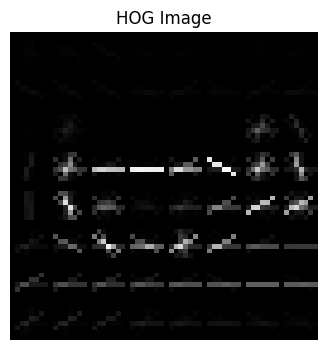

Text(0.5, 1.0, 'Original Image')

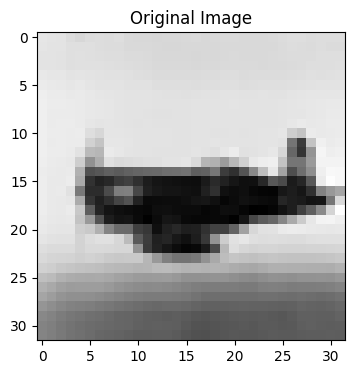

In [64]:
def compute_hog(img):
    # Resize the image while preserving aspect ratio
    resized_img = resize(img, (64, 64))
    # Compute HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

# Read an example image
Hog_feature, hog_image = compute_hog(X_train[115])

# Plot the HOG image
plt.figure(figsize=(8, 4))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()
plt.figure(figsize=(8, 4))
plt.imshow(X_train[115])
plt.title("Original Image")

Now applying the previously trained classical ML models, to check classification and comparing performance.


#### KNN


In [113]:
knn_classifier = KNeighborsClassifier(n_neighbors=8)
# Train the classifier
knn_classifier.fit(all_hog_features_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(all_hog_features_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)


Accuracy of KNN: 0.5235
Precision of KNN: 0.5721330502598757
Recall of KNN: 0.5235
F1 Score of KNN: 0.5180642025224663


#### Decision Tree

In [114]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(all_hog_features_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(all_hog_features_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)


Accuracy of Decision Tree Classifier: 0.2794
Precision of Decision Tree Classifier: 0.28082027923761443
Recall of Decision Tree Classifier: 0.2794
F1 Score of Decision Tree Classifier: 0.28001844291335454


#### Random Forest Classifier

In [115]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(all_hog_features_train, y_train)

y_pred_random_forest = random_forest_model.predict(all_hog_features_test)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.5208
Precision of Random Forest Classifier: 0.5185889984825872
Recall of Random Forest Classifier: 0.5208
F1 Score of Random Forest Classifier: 0.5164237303674691


#### Naive Bayes Classifier

In [116]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(all_hog_features_train, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(all_hog_features_test)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.4581
Precision of Naive Bayes Classifier: 0.4667085487081605
Recall of Naive Bayes Classifier: 0.4581
F1 Score of Naive Bayes Classifier: 0.4536907851130096


### SVM

In [117]:
# Train the SVM model
svm_classifier = SVC(kernel='poly', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(all_hog_features_train, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(all_hog_features_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Accuracy of SVM Classifier:", accuracy_svm)
print("Precision of SVM Classifier:", precision_svm)
print("Recall of SVM Classifier:", recall_svm)
print("F1 Score of SVM Classifier:", f1_svm)

Accuracy of SVM Classifier: 0.632
Precision of SVM Classifier: 0.6320034037370231
Recall of SVM Classifier: 0.632
F1 Score of SVM Classifier: 0.6311975017224


In [118]:
# Train the SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(all_hog_features_train, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(all_hog_features_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Accuracy of SVM Classifier:", accuracy_svm)
print("Precision of SVM Classifier:", precision_svm)
print("Recall of SVM Classifier:", recall_svm)
print("F1 Score of SVM Classifier:", f1_svm)

Accuracy of SVM Classifier: 0.6437
Precision of SVM Classifier: 0.6421604785165514
Recall of SVM Classifier: 0.6437
F1 Score of SVM Classifier: 0.6421912268027985


In [68]:
print(all_hog_features_train.shape)


(50000, 324)


### ANN

In [102]:
from tensorflow.keras.utils import to_categorical

# Convert target arrays to one-hot encoded format
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Define the model
simple_model = Sequential([
    Dense(8000, input_shape=(324,), activation='relu'),
    Dense(5000, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
simple_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
simple_model_history = simple_model.fit(all_hog_features_train, y_train_one_hot, batch_size=100, epochs=8, validation_data=(all_hog_features_test, y_test_one_hot))


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 142ms/step - accuracy: 0.2571 - loss: 2.2616 - val_accuracy: 0.3713 - val_loss: 2.1245
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 131ms/step - accuracy: 0.3802 - loss: 2.0714 - val_accuracy: 0.4000 - val_loss: 1.9286
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 131ms/step - accuracy: 0.4079 - loss: 1.8966 - val_accuracy: 0.4183 - val_loss: 1.8033
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.4311 - loss: 1.7769 - val_accuracy: 0.4362 - val_loss: 1.7036
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 132ms/step - accuracy: 0.4467 - loss: 1.6887 - val_accuracy: 0.4587 - val_loss: 1.6273
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 132ms/step - accuracy: 0.4603 - loss: 1.6131 - val_accuracy: 0.4643 - val_loss: 1.5757
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 132ms/step - accuracy: 0.4711 - loss: 1.5647 - val_accuracy: 0.4713 - val_loss: 1.5372
Epoch 8/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - accuracy: 0.4799 - loss: 1.5251 - 

In [103]:
# Predict classes for the test set
y_pred = simple_model.predict(all_hog_features_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to categorical labels
y_test_categorical = np.argmax(y_test_one_hot, axis=1)

# Calculate precision
precision = precision_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Calculate recall
recall = recall_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test_categorical, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision",precision)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Accuracy: 0.4791
Recall: 0.4791
F1 Score: 0.4700522150062764
Precision 0.4712464311333888


Adding more layers

In [104]:
simple_model_more_layers = Sequential()
simple_model_more_layers.add(Dense(8000, input_shape=(324,), activation='relu'))
simple_model_more_layers.add(Dense(8000, activation='relu'))
simple_model_more_layers.add(Dense(5000, activation='relu'))
simple_model_more_layers.add(Dense(10, activation='softmax'))

simple_model_more_layers.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
simple_model_history = simple_model.fit(all_hog_features_train, y_train_one_hot, batch_size=80, epochs=12, validation_data=(all_hog_features_test, y_test_one_hot))


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step - accuracy: 0.4877 - loss: 1.4980 - val_accuracy: 0.4870 - val_loss: 1.4827
Epoch 2/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.4912 - loss: 1.4784 - val_accuracy: 0.4962 - val_loss: 1.4590
Epoch 3/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 108ms/step - accuracy: 0.5033 - loss: 1.4473 - val_accuracy: 0.4959 - val_loss: 1.4435
Epoch 4/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.5136 - loss: 1.4210 - val_accuracy: 0.5046 - val_loss: 1.4257
Epoch 5/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.5137 - loss: 1.4049 - val_accuracy: 0.5072 - val_loss: 1.4131
Epoch 6/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.5165 - loss: 1.3962 - val_accuracy: 0.5150 - val_loss: 1.3987
Epoch 7/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.5245 - loss: 1.3744 - val_accuracy: 0.5191 - val_loss: 1.3846
Epoch 8/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.5254 - loss: 1

In [105]:
# Predict classes for the test set
y_pred = simple_model_more_layers.predict(all_hog_features_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to categorical labels
y_test_categorical = np.argmax(y_test_one_hot, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Calculate precision
precision = precision_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate recall
recall = recall_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test_categorical, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
Accuracy: 0.0838
Precision: 0.07480417259089031
Recall: 0.0838
F1 Score: 0.04942182241562287


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Feature Extraction and Tuning parameters**

### ResNet Features

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [24]:
# Calculate mean and standard deviation
mean_data = np.mean(X_train, axis=(0, 1, 2)) / 255  
std_data = np.std(X_train, axis=(0, 1, 2)) / 255  

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_data, std=std_data),
    ])
# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# resnet = models.resnet50(weights='imagenet')

# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()
all_features = []
X_train_features = []
for image_data in X_train:
    image = Image.fromarray(image_data)  #Converting to type PIL.Image
    image = preprocess(image)
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = resnet(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    all_features.append(features.numpy())
    X_train_features.append(features.numpy())

X_test_features = []
for image_data in X_test:
    image = Image.fromarray(image_data)  #Converting to type PIL.Image
    image = preprocess(image)
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = resnet(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    all_features.append(features.numpy())
    X_test_features.append(features.numpy())

# all_features_tensor = torch.tensor(all_features)
all_features_array = np.array(all_features)
all_features_tensor = torch.tensor(all_features_array)
# Save the extracted features to a file
torch.save(all_features_tensor, 'extracted_features.pt')

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
print(all_features_tensor.shape)

torch.Size([60000, 2048, 1, 1])


Loading the saved features and selecting the training data and testing data

In [122]:
# Load the saved features from the file
loaded_features = torch.load('extracted_features.pt')
X_train_features = loaded_features[:50000]
X_test_features = loaded_features[50000:]

In [123]:
print(X_train.shape)
# Changing the shape
X_train_CNN = np.array(X_train_features).reshape(X_train.shape[0], -1)
X_test_CNN = np.array(X_test_features).reshape(X_test.shape[0], -1)
print(X_train_CNN.shape)

(50000, 32, 32, 3)
(50000, 2048)


### KNN

In [28]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)

# Train the classifier
knn_classifier.fit(X_train_CNN, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_CNN)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.8408
Precision of KNN: 0.8449391444512696
Recall of KNN: 0.8408
F1 Score of KNN: 0.840755764730697


Finding optimum value of 'k'

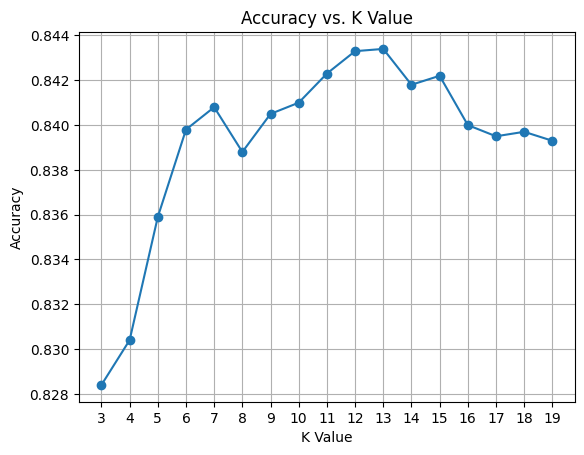

Best value of k: 13


In [29]:
import matplotlib.pyplot as plt

# Define a range of k values to try
k_values = range(3, 20)  # You can adjust the range as needed

# Initialize lists to store accuracies for each k
accuracies = []

# Iterate over each value of k
for k in k_values:
    # Create and train the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_CNN, y_train)
    
    # Predict labels for the validation set
    y_pred = knn_classifier.predict(X_test_CNN)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot k versus accuracy
plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Find the k value with the highest accuracy
best_k = k_values[accuracies.index(max(accuracies))]
print("Best value of k:", best_k)


In [124]:
#using the best value of k
knn_classifier = KNeighborsClassifier(n_neighbors=13)

# Train the classifier
knn_classifier.fit(X_train_CNN, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_CNN)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.8434
Precision of KNN: 0.848380873014827
Recall of KNN: 0.8434
F1 Score of KNN: 0.8432689748734811


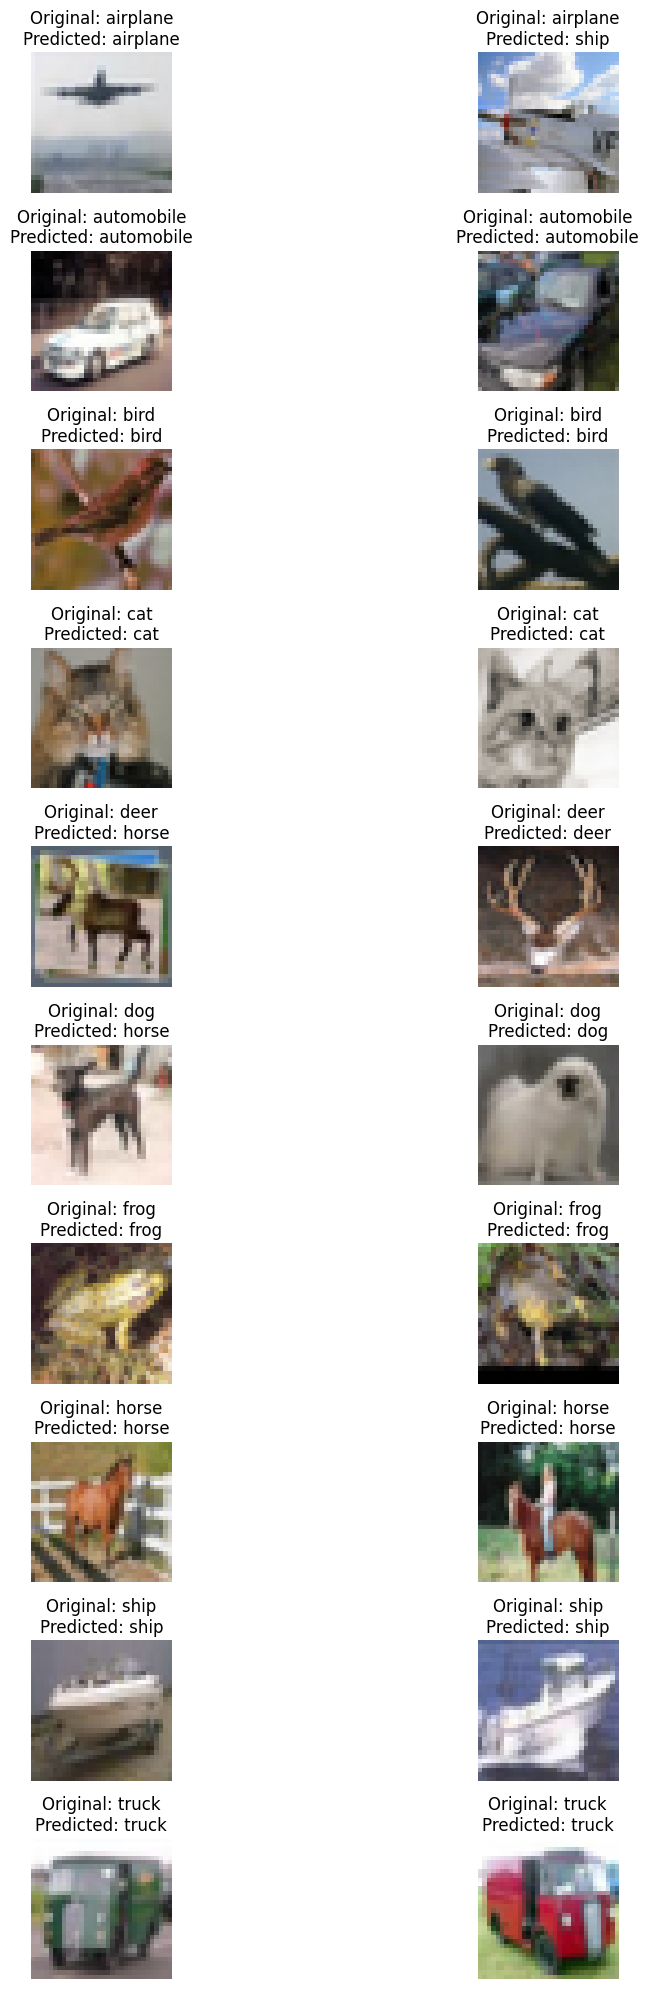

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images along with their labels
def plot_images(images, true_labels, pred_labels, class_names):
    num_classes = len(class_names)
    num_examples_per_class = 2
    fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(12, 2*num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'Original: {class_names[true_labels[idx]]}\nPredicted: {class_names[pred_labels[idx]]}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Show images with original and predicted labels
plot_images(X_test, y_test, y_pred, class_names)


Finding inaccuracies

Misclassifications count per class:
Class 6: 99 misclassifications
Class 5: 238 misclassifications
Class 7: 169 misclassifications
Class 4: 178 misclassifications
Class 1: 76 misclassifications
Class 3: 211 misclassifications
Class 2: 291 misclassifications
Class 0: 145 misclassifications
Class 9: 96 misclassifications
Class 8: 63 misclassifications


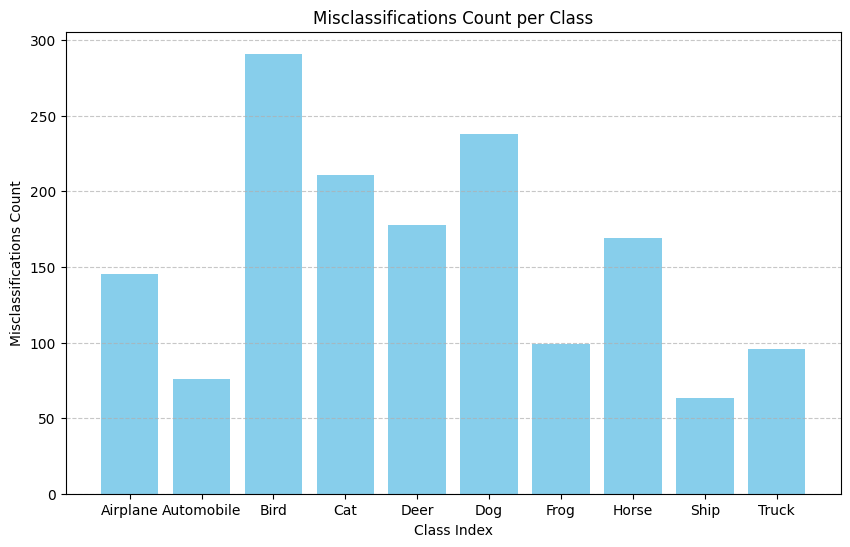

In [31]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test_CNN)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


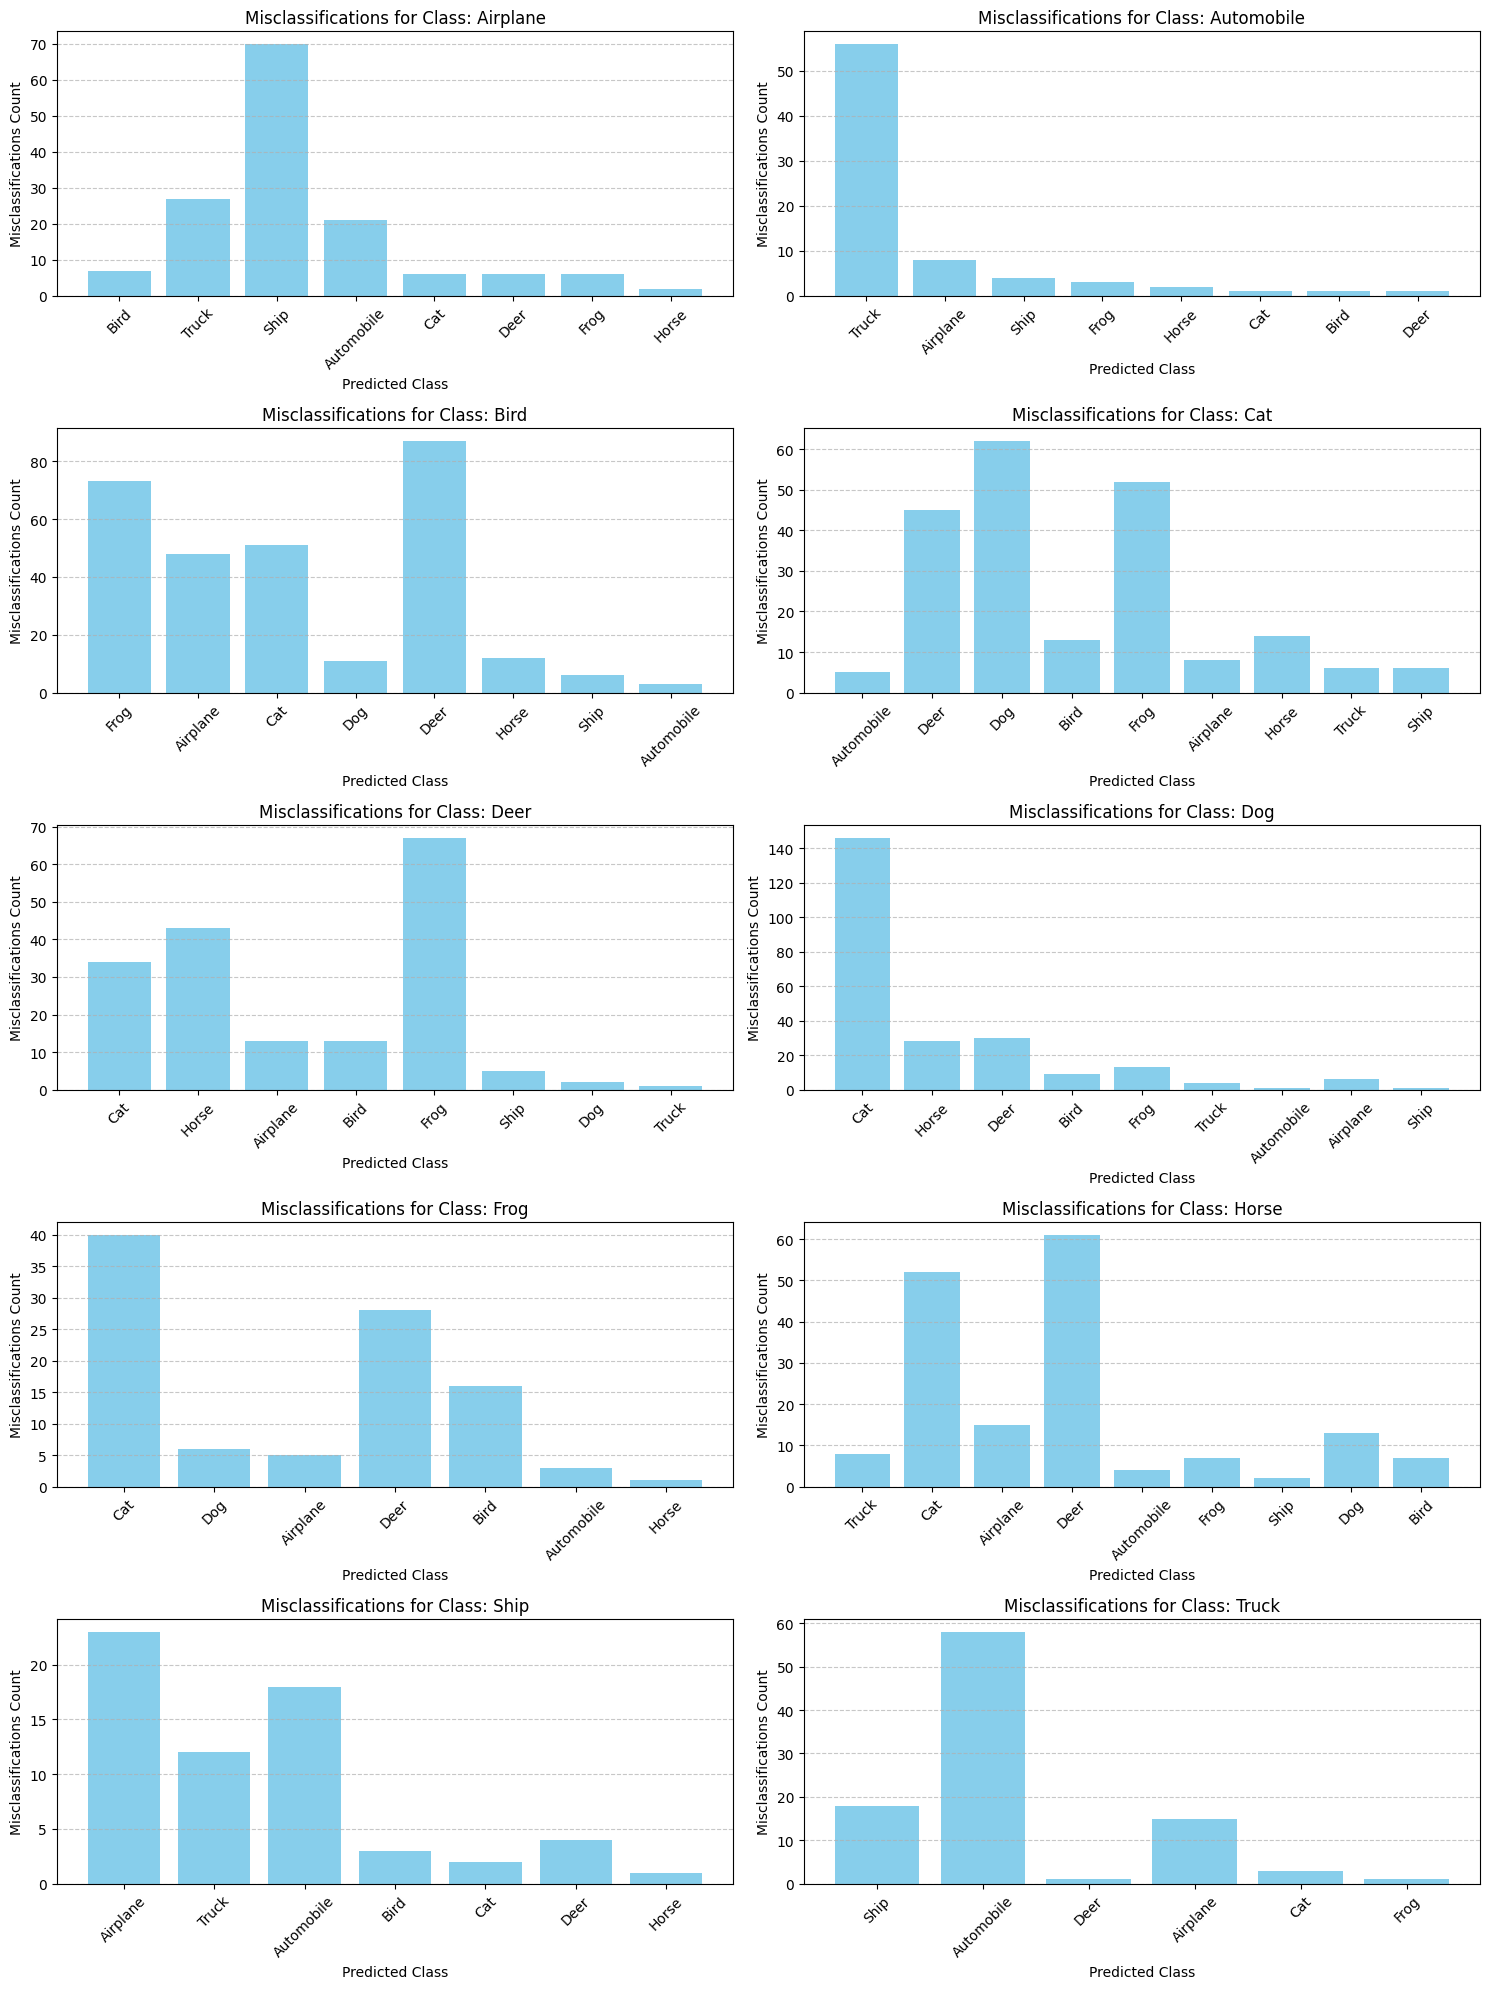

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Decision Tree

In [33]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion= "gini")
decision_tree_model.fit(X_train_CNN, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_CNN)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.649
Precision of Decision Tree Classifier: 0.6497237121050045
Recall of Decision Tree Classifier: 0.649
F1 Score of Decision Tree Classifier: 0.6492771071867106


In [34]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion= "entropy")
decision_tree_model.fit(X_train_CNN, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_CNN)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.6495
Precision of Decision Tree Classifier: 0.6497659242272994
Recall of Decision Tree Classifier: 0.6495
F1 Score of Decision Tree Classifier: 0.6495129799853556


In [127]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion= "entropy" , max_depth = 10 , min_samples_leaf = 10 , min_samples_split = 15)
decision_tree_model.fit(X_train_CNN, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_CNN)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.6721
Precision of Decision Tree Classifier: 0.6759435793422367
Recall of Decision Tree Classifier: 0.6721
F1 Score of Decision Tree Classifier: 0.6725786767141699


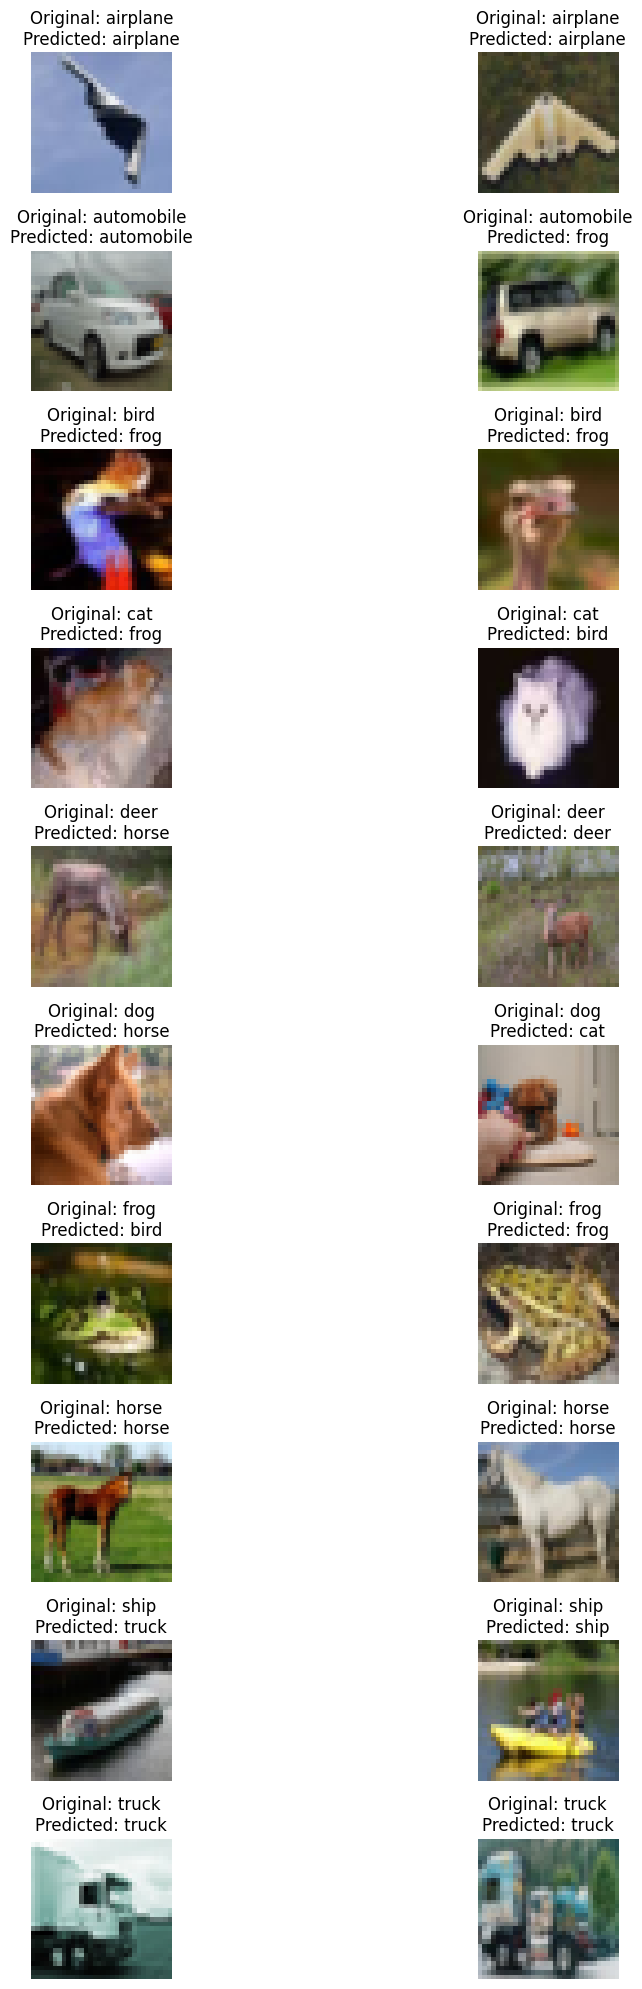

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images along with their labels
def plot_images(images, true_labels, pred_labels, class_names):
    num_classes = len(class_names)
    num_examples_per_class = 2
    fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(12, 2*num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'Original: {class_names[true_labels[idx]]}\nPredicted: {class_names[pred_labels[idx]]}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Show images with original and predicted labels
plot_images(X_test, y_test, y_pred_decision_tree, class_names)


In [36]:
from sklearn.model_selection import GridSearchCV

dt_hp = DecisionTreeClassifier()
params = {'max_depth':[8,10,12],
          'min_samples_leaf':[10, 12, 14],
          'min_samples_split':[10,13,15 , 17],
          'criterion':['entropy']}
GS = GridSearchCV(estimator=dt_hp,param_grid=params,cv=3,n_jobs=-1, verbose=True, scoring='accuracy')
GS.fit(X_train_CNN, y_train)
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

Misclassifications count per class:
Class 8: 232 misclassifications
Class 6: 291 misclassifications
Class 0: 294 misclassifications
Class 5: 369 misclassifications
Class 7: 379 misclassifications
Class 4: 390 misclassifications
Class 2: 454 misclassifications
Class 1: 240 misclassifications
Class 9: 208 misclassifications
Class 3: 413 misclassifications


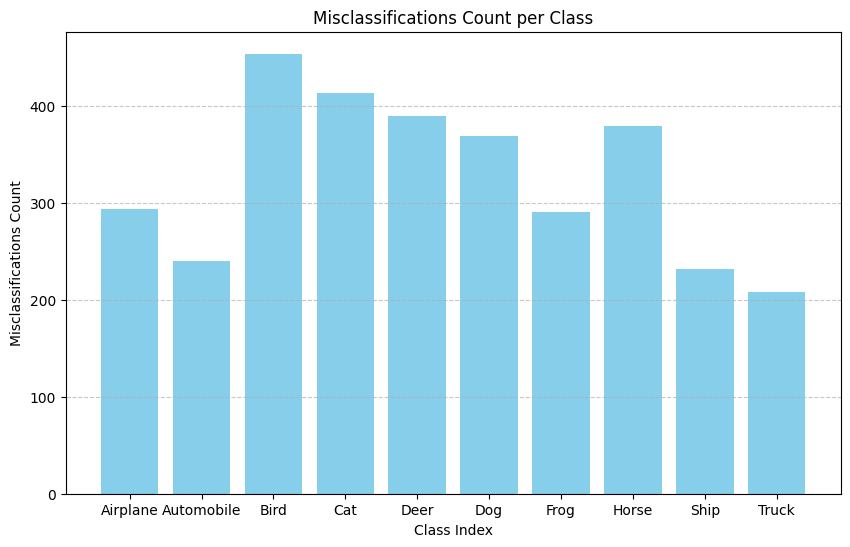

In [37]:
from collections import defaultdict
import matplotlib.pyplot as plt
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test_CNN)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


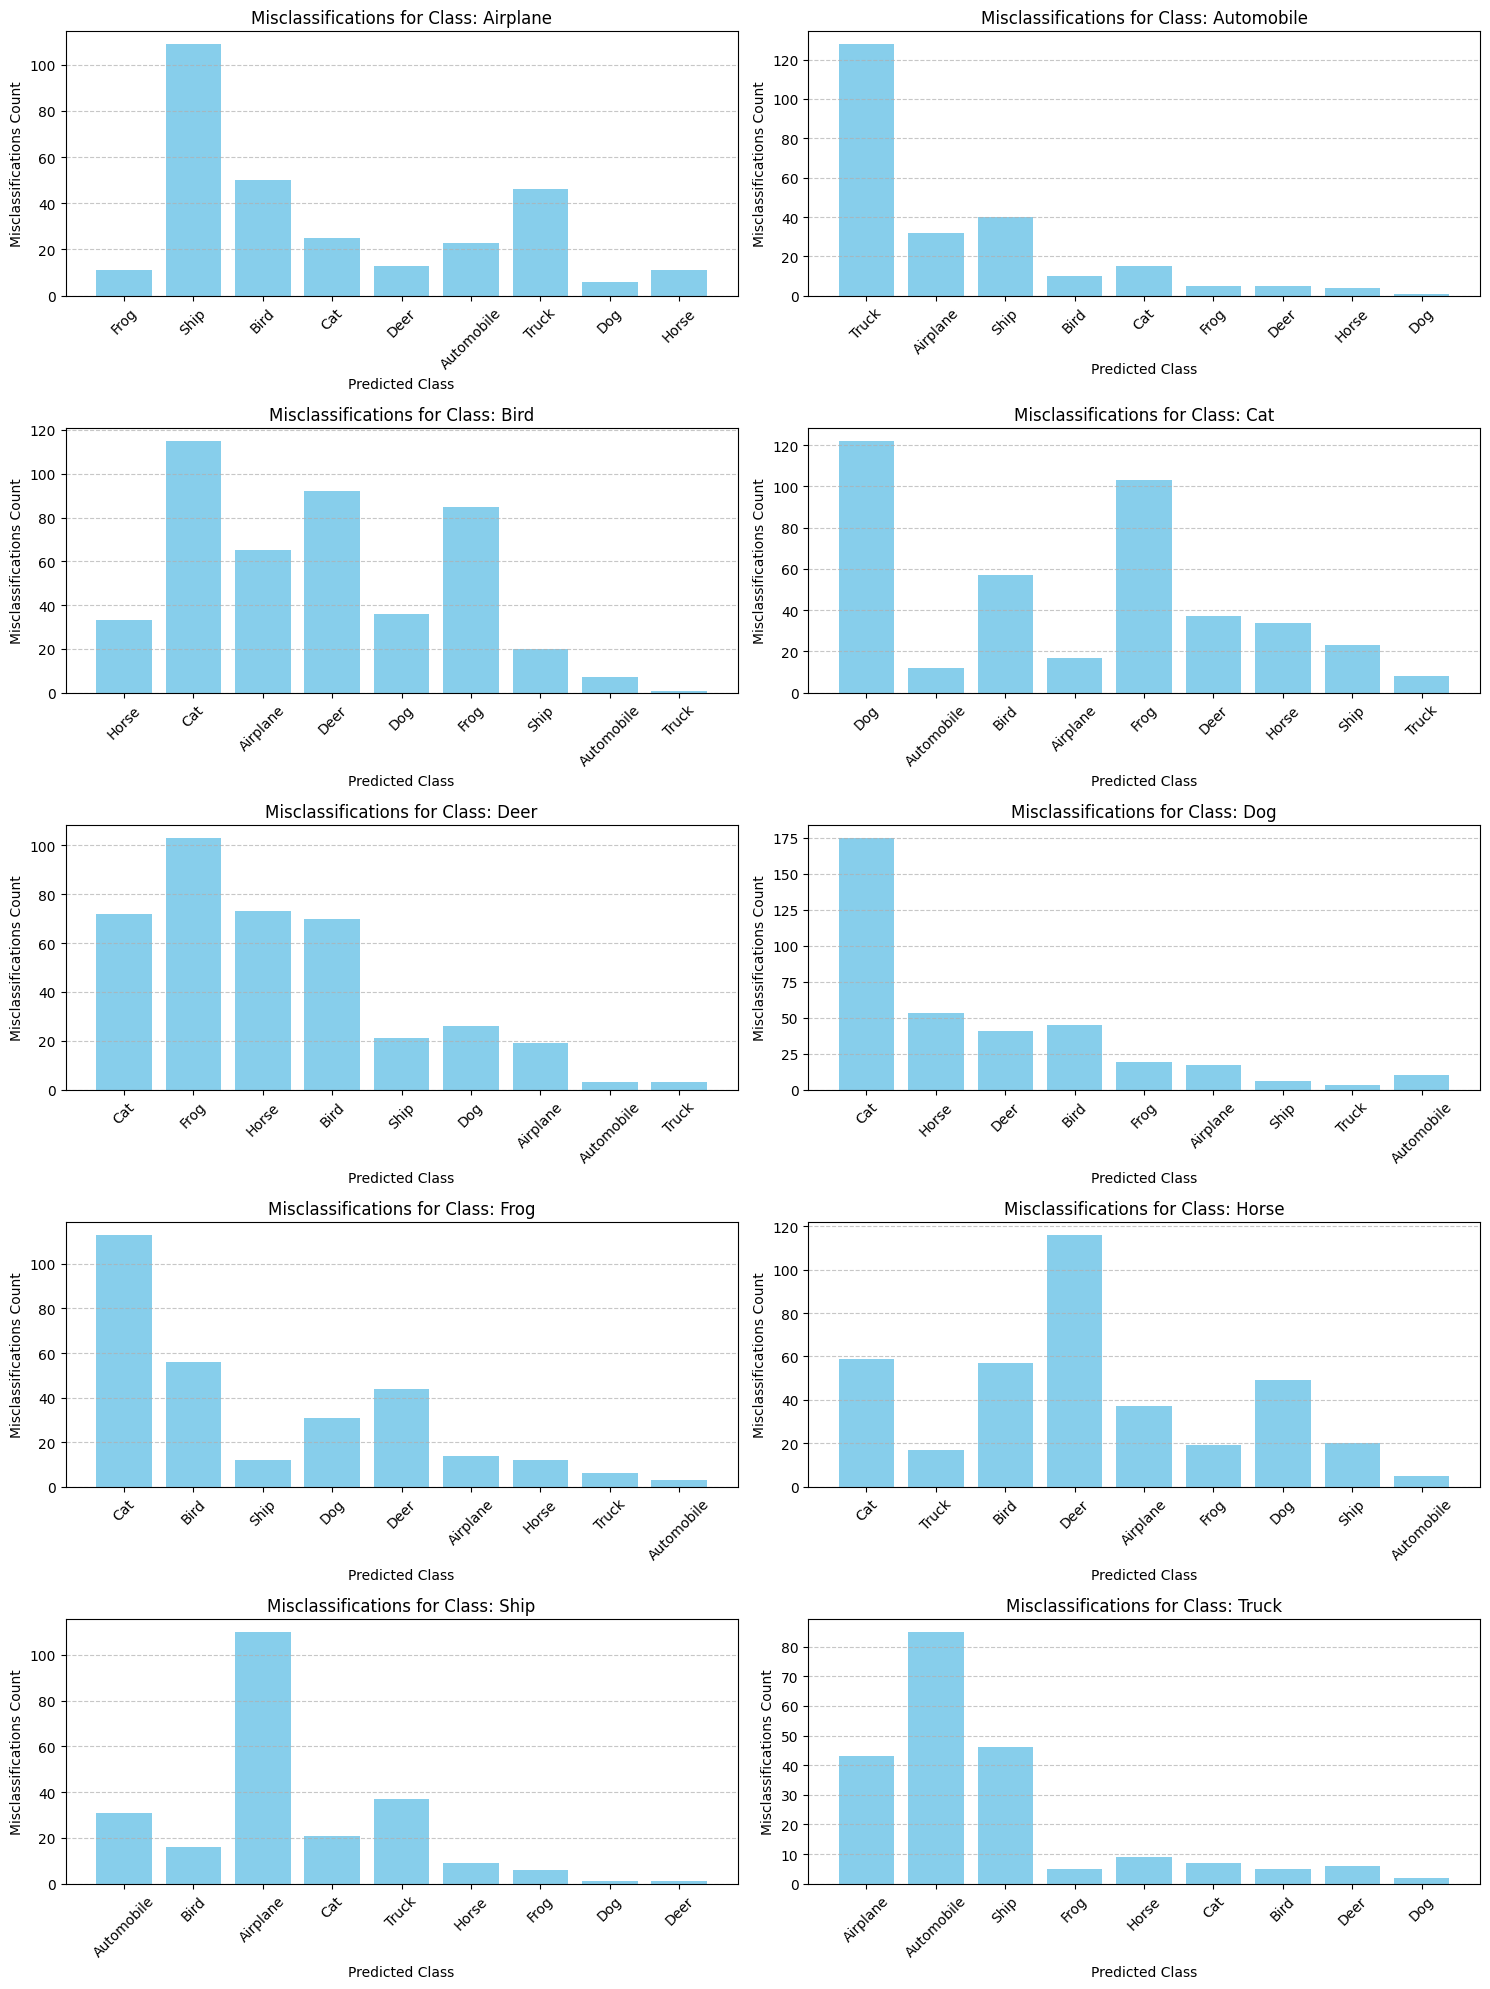

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Random Forest

In [131]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators= 250 , max_depth = 10 , min_samples_leaf = 10 , min_samples_split = 15)
random_forest_model.fit(X_train_CNN, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_CNN)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.8146
Precision of Random Forest Classifier: 0.8186296323166092
Recall of Random Forest Classifier: 0.8146
F1 Score of Random Forest Classifier: 0.814676460617399


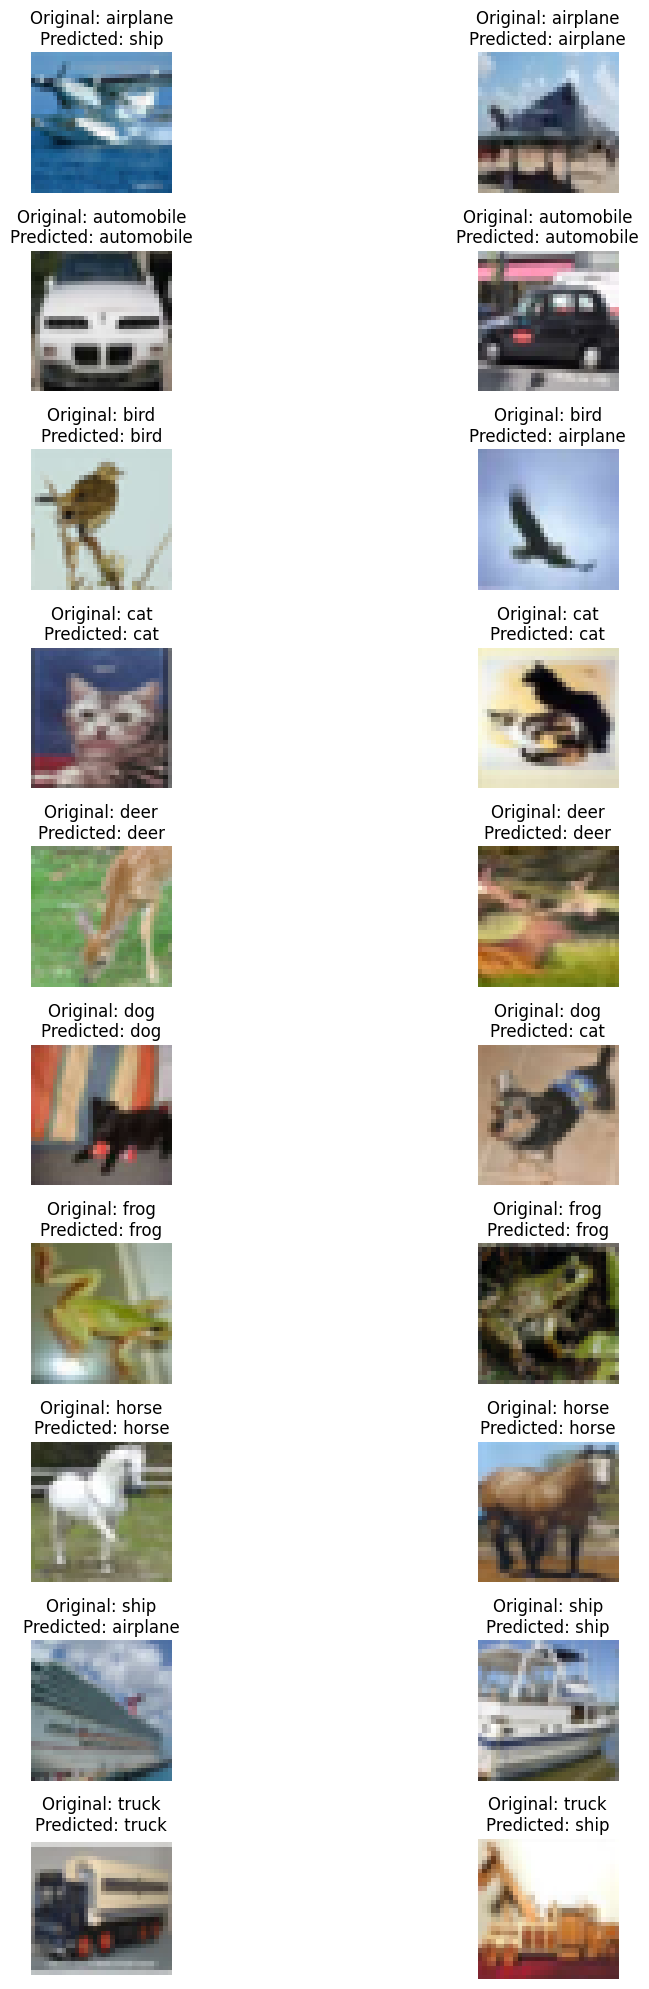

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images along with their labels
def plot_images(images, true_labels, pred_labels, class_names):
    num_classes = len(class_names)
    num_examples_per_class = 2
    fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(12, 2*num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'Original: {class_names[true_labels[idx]]}\nPredicted: {class_names[pred_labels[idx]]}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Show images with original and predicted labels
plot_images(X_test, y_test, y_pred_random_forest, class_names)


In [ ]:
# from sklearn.model_selection import GridSearchCV

# rf_hp = RandomForestClassifier()
# params = {'max_depth':[8,10 , 12],
#           'min_samples_leaf':[8 ,10 ,12],
#           'min_samples_split':[13,15,17],
#           'n_estimators': [250,300]
#           }
# GS = GridSearchCV(estimator=rf_hp,param_grid=params,cv=2,n_jobs=-1, verbose=True, scoring='accuracy')
# GS.fit(X_train_CNN, y_train)
# print('Best Parameters:',GS.best_params_,end='\n\n')
# print('Best Score:',GS.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 250}

Best Score: 0.82062


Misclassifications count per class:
Class 8: 85 misclassifications
Class 4: 251 misclassifications
Class 2: 305 misclassifications
Class 1: 109 misclassifications
Class 9: 119 misclassifications
Class 6: 129 misclassifications
Class 7: 238 misclassifications
Class 3: 245 misclassifications
Class 5: 235 misclassifications
Class 0: 161 misclassifications


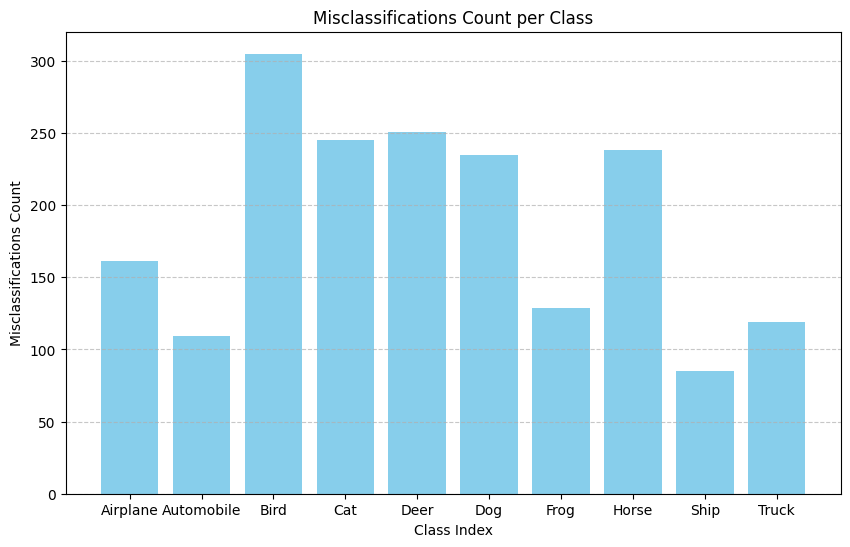

In [40]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test_CNN)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


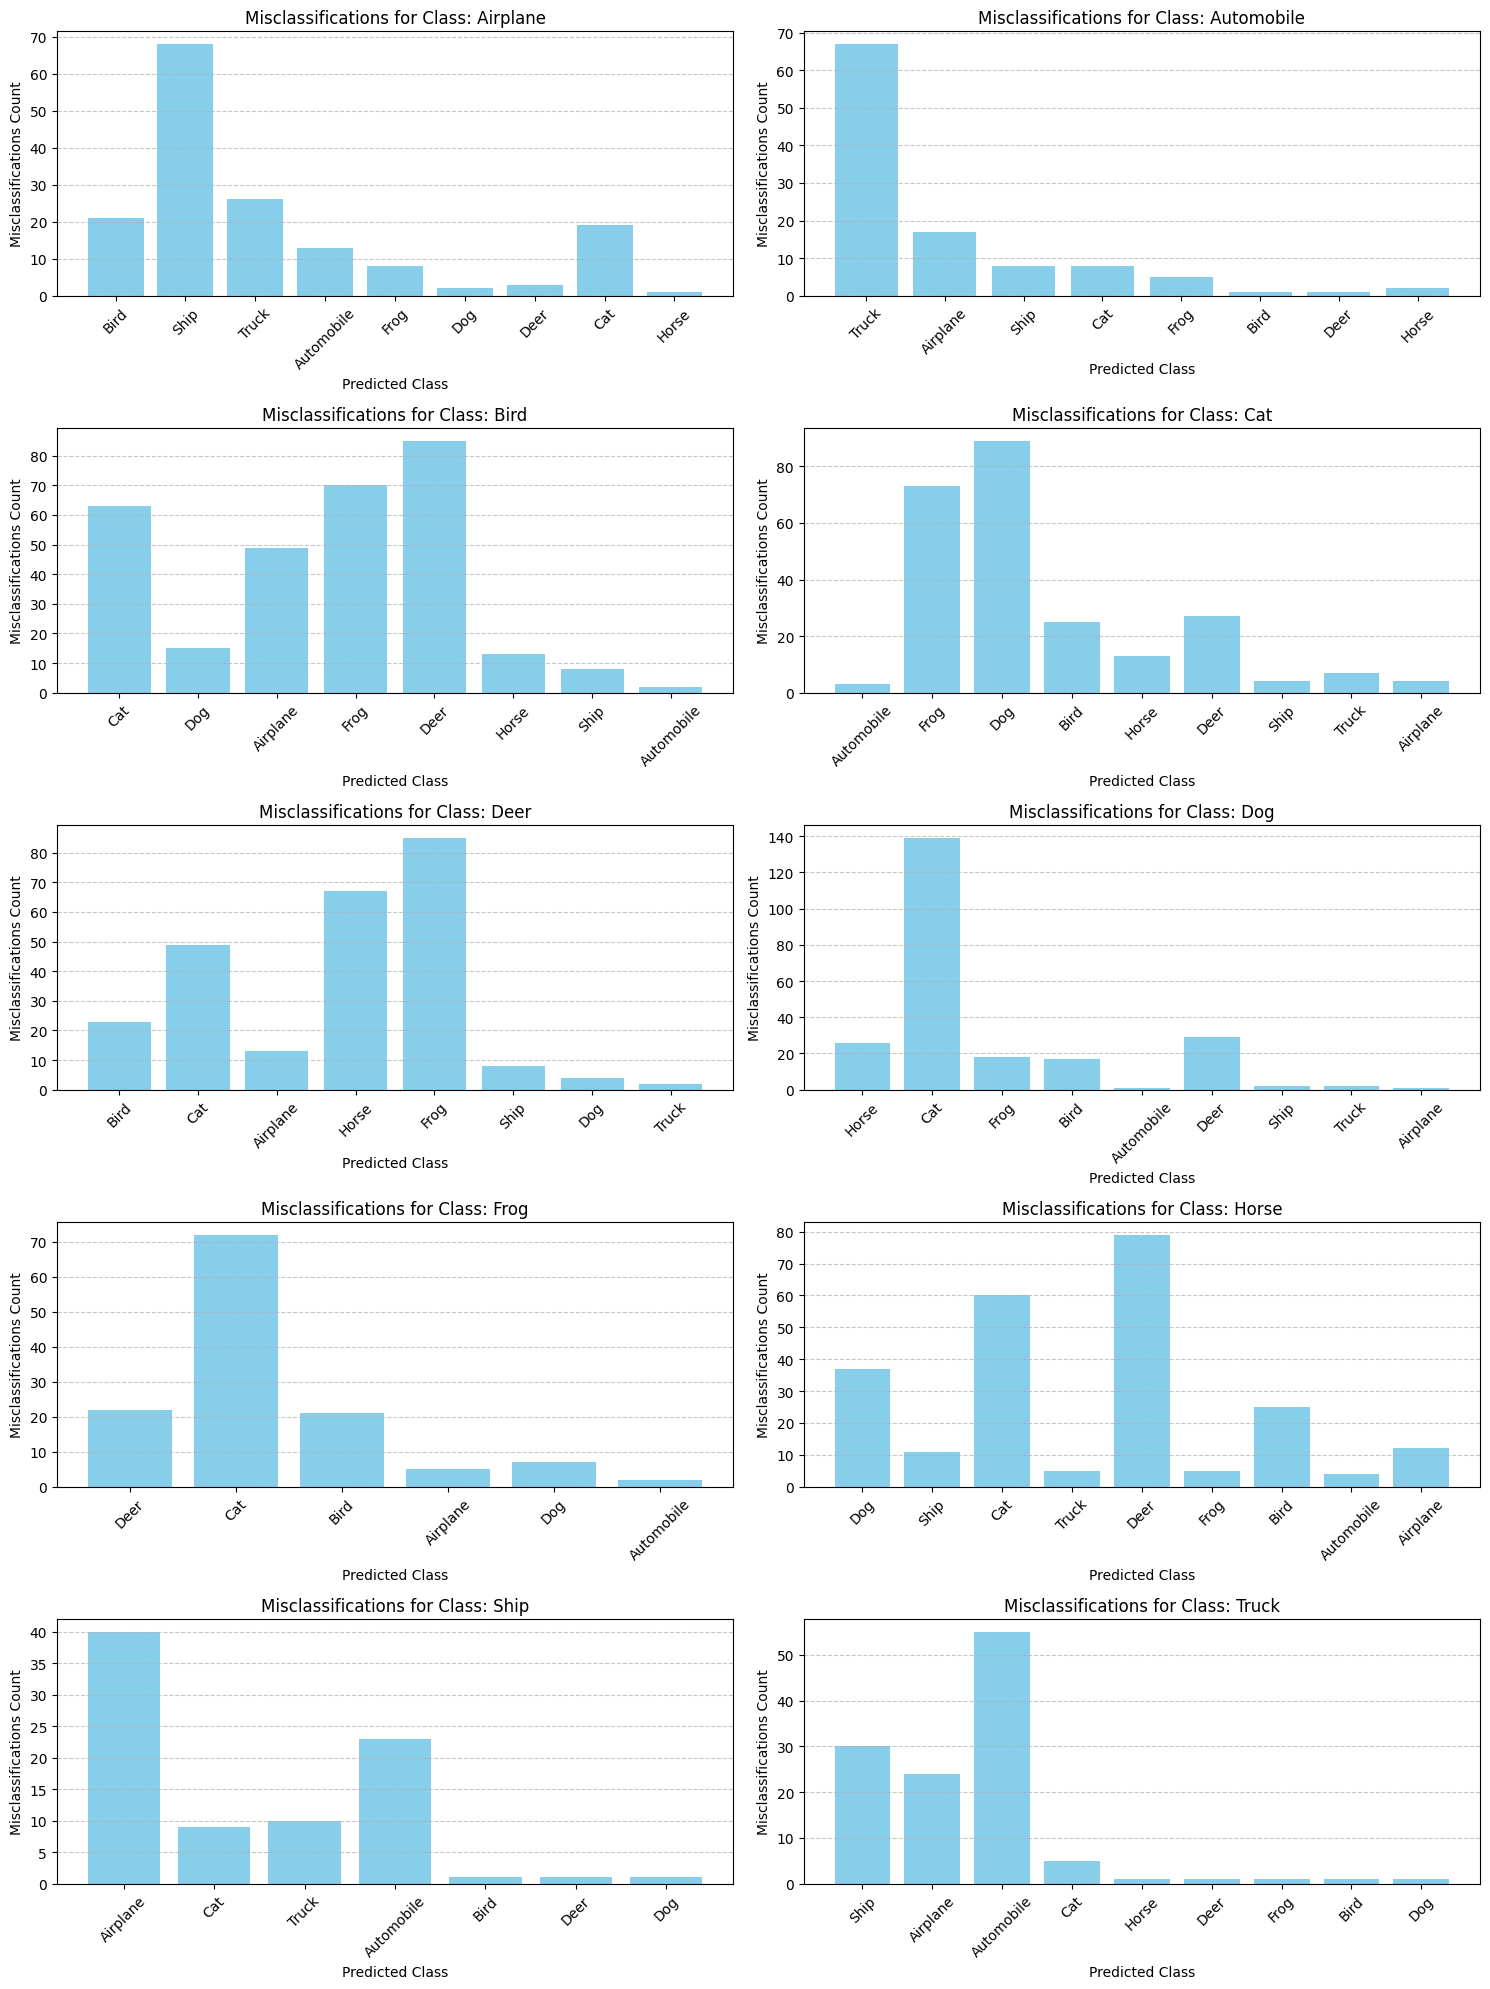

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Naive Bayes

In [42]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_CNN, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_CNN)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)


Accuracy of Naive Bayes Classifier: 0.7916
Precision of Naive Bayes Classifier: 0.7945136947402487
Recall of Naive Bayes Classifier: 0.7916
F1 Score of Naive Bayes Classifier: 0.7915931712670695


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid
param_grid = {
    'alpha': [1.0, 2.0, 2.5 , 3.0 , 5.0]  # You can adjust the range of alpha values
}

# Initialize Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(mnb_classifier, param_grid, cv=3, n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train_CNN, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best model
best_mnb_classifier = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_mnb_classifier.predict(X_test_CNN)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Best hyperparameters found:
{'alpha': 2.0}
Accuracy: 0.7915


In [133]:

# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_CNN, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_CNN)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.7948
Precision of Naive Bayes Classifier: 0.797058885568306
Recall of Naive Bayes Classifier: 0.7948
F1 Score of Naive Bayes Classifier: 0.794656614631248


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # You can adjust the range of var_smoothing values
}

# Initialize Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(gnb_classifier, param_grid, cv=3, n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train_CNN, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best model
best_gnb_classifier = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_gnb_classifier.predict(X_test_CNN)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best hyperparameters found:
{'var_smoothing': 1e-09}
Accuracy: 0.7948


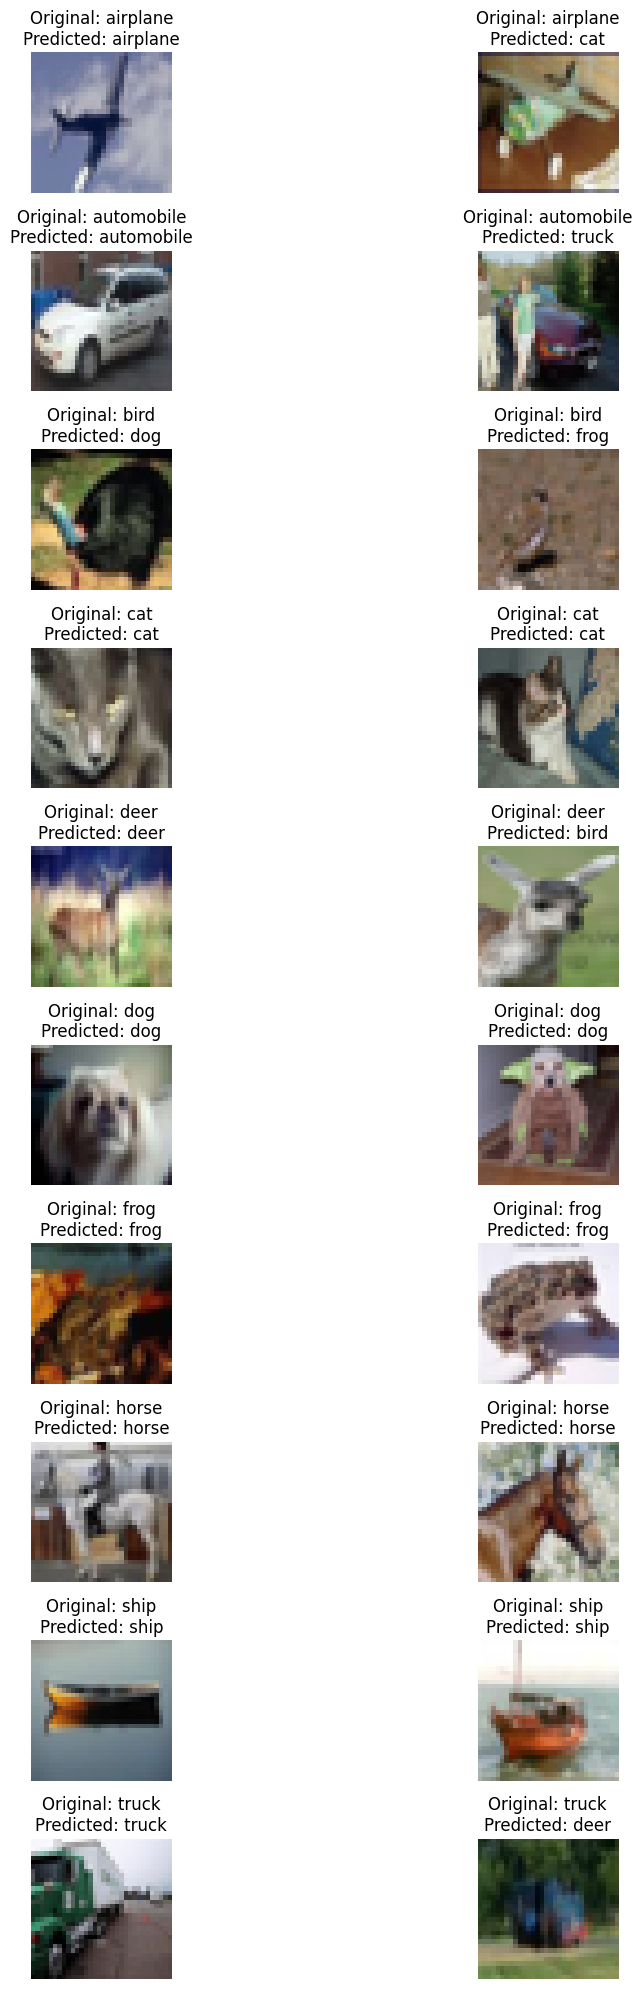

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images along with their labels
def plot_images(images, true_labels, pred_labels, class_names):
    num_classes = len(class_names)
    num_examples_per_class = 2
    fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(12, 2*num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'Original: {class_names[true_labels[idx]]}\nPredicted: {class_names[pred_labels[idx]]}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Show images with original and predicted labels
plot_images(X_test, y_test, y_pred_naive_bayes, class_names)


Misclassifications count per class:
Class 6: 150 misclassifications
Class 8: 96 misclassifications
Class 4: 262 misclassifications
Class 2: 327 misclassifications
Class 3: 294 misclassifications
Class 7: 238 misclassifications
Class 1: 135 misclassifications
Class 5: 228 misclassifications
Class 0: 207 misclassifications
Class 9: 115 misclassifications


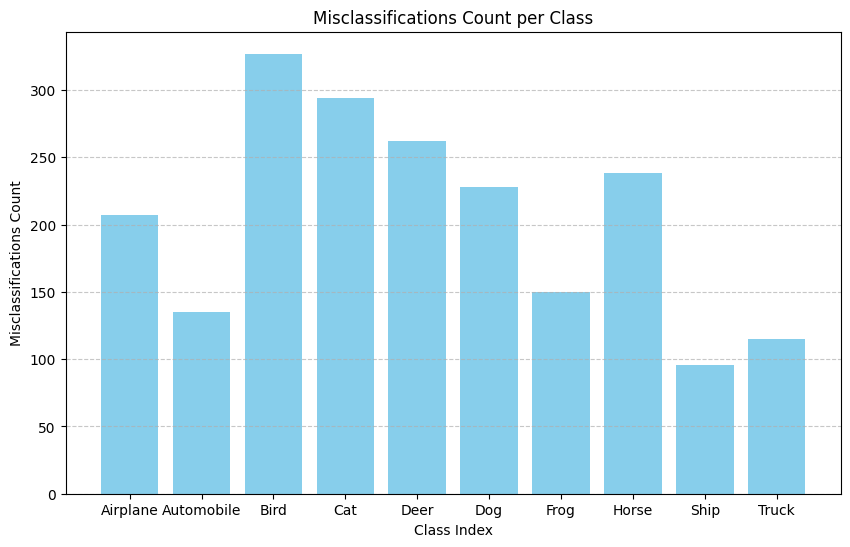

In [46]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = naive_bayes_model.predict(X_test_CNN)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


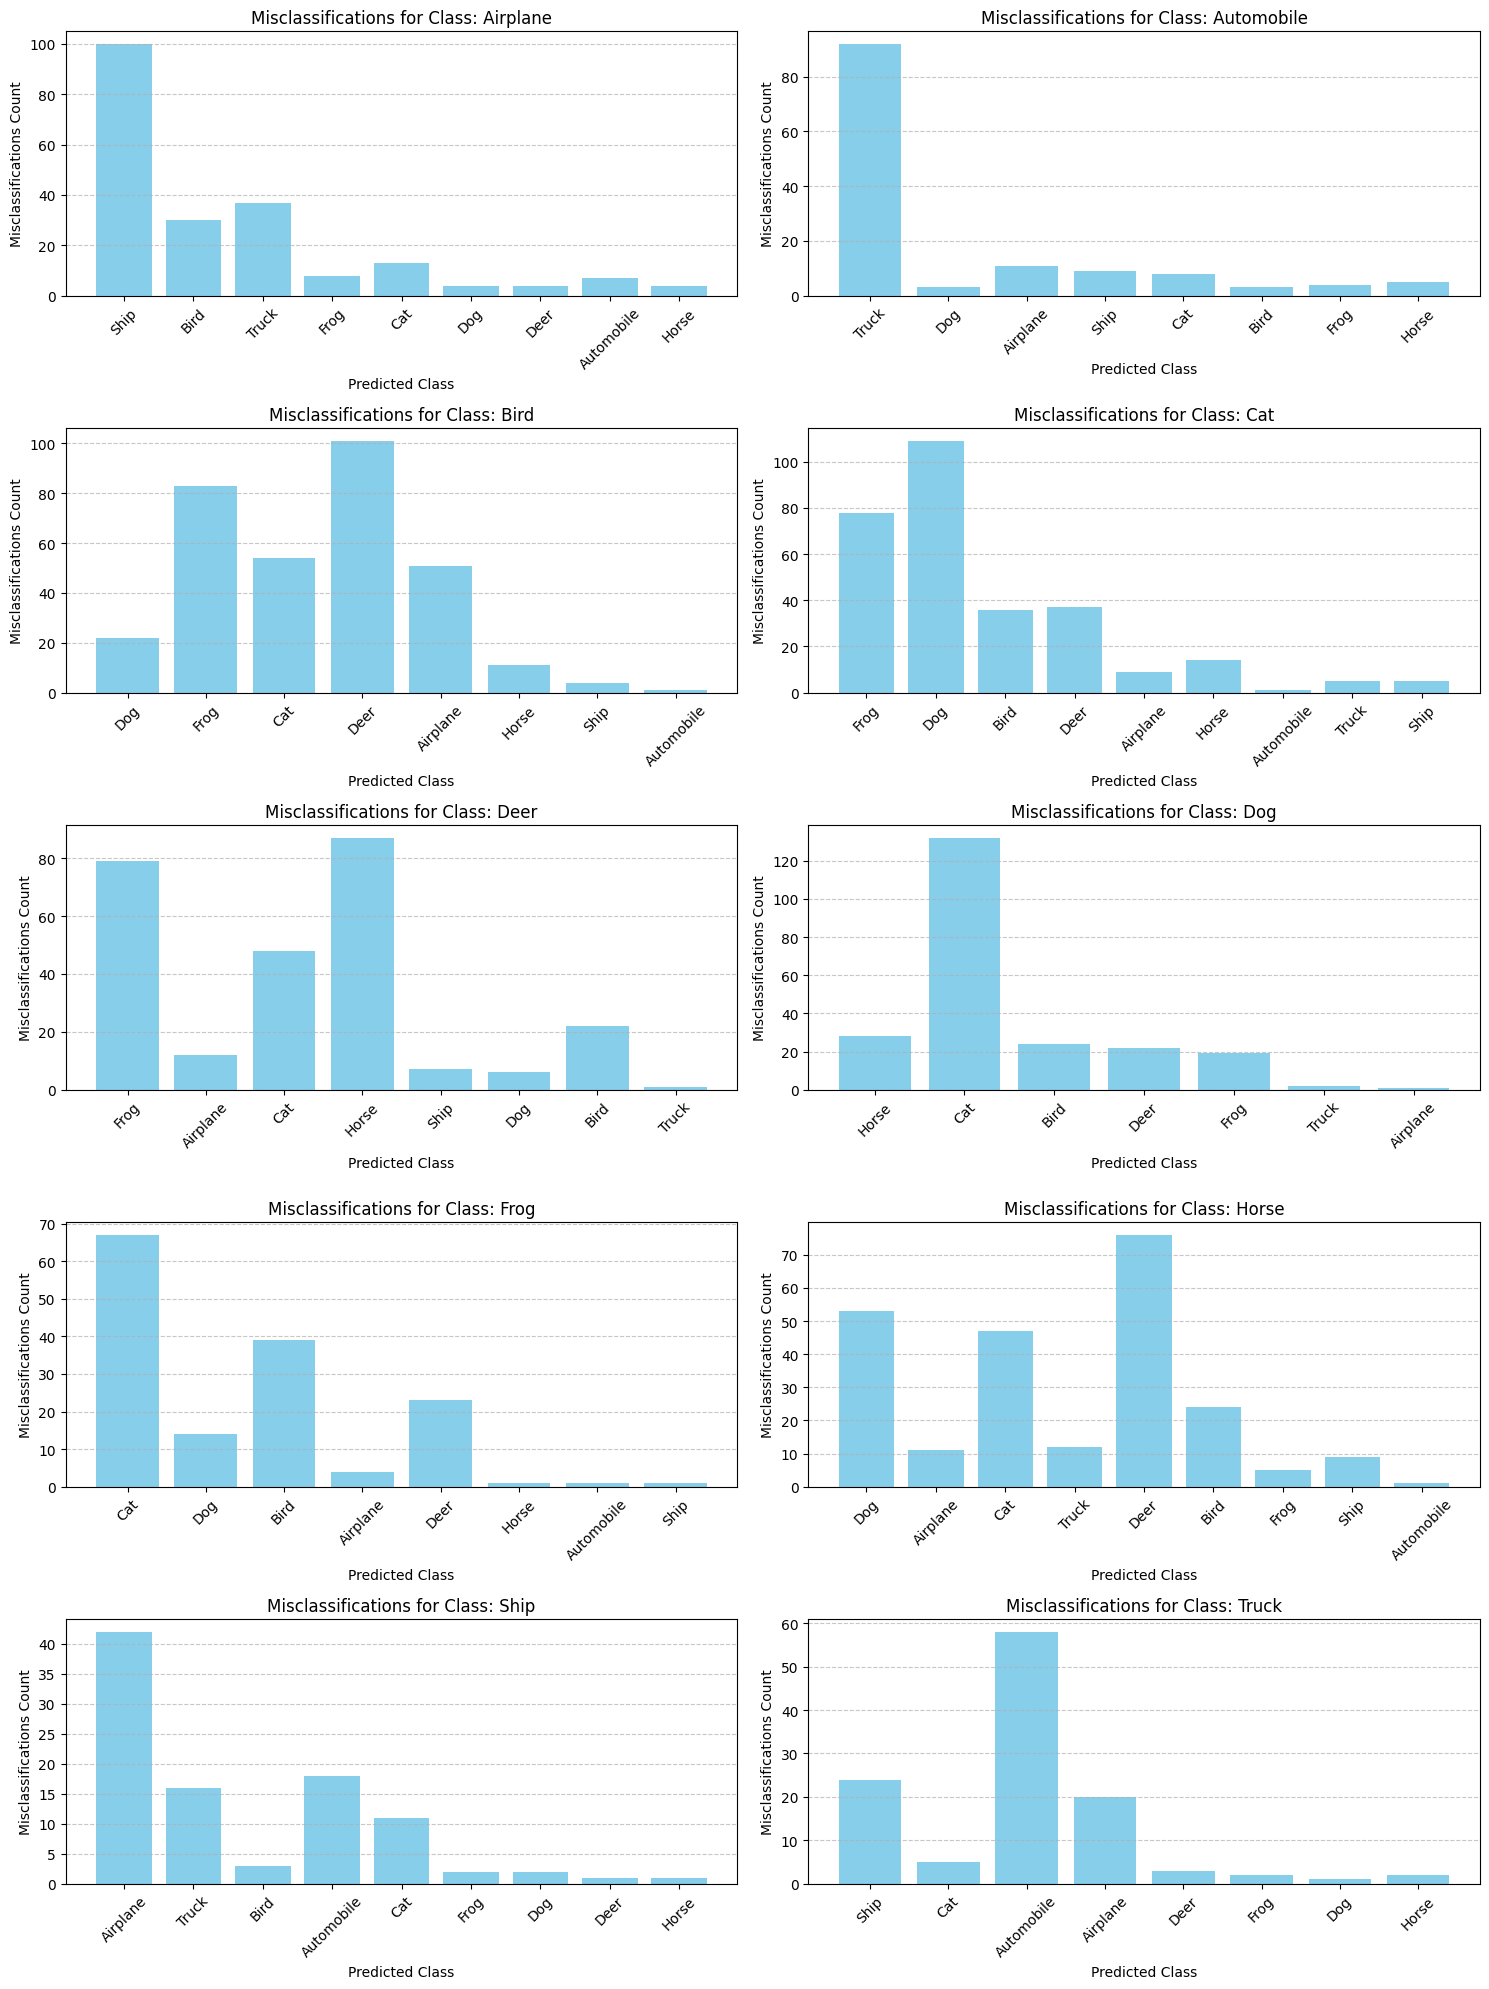

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### SVM


In [135]:
# Train the SVM model
svm_classifier = SVC(kernel='poly', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train_CNN, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(X_test_CNN)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy)
print("Precision of Naive Bayes Classifier:", precision)
print("Recall of Naive Bayes Classifier:", recall)
print("F1 Score of Naive Bayes Classifier:", f1)


Accuracy of Naive Bayes Classifier: 0.8434
Precision of Naive Bayes Classifier: 0.848380873014827
Recall of Naive Bayes Classifier: 0.8434
F1 Score of Naive Bayes Classifier: 0.8432689748734811


In [49]:
# Train the SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train_CNN, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_CNN)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy)
print("Precision of Naive Bayes Classifier:", precision)
print("Recall of Naive Bayes Classifier:", recall)
print("F1 Score of Naive Bayes Classifier:", f1)


Accuracy: 0.8919


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.8, 1, 2],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm_classifier = SVC()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3)

# Fit the Grid Search to the data
grid_search.fit(X_train_CNN, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)
print("Accuracy:", accuracy)
print('Best Score:',GS.best_score_)



KeyboardInterrupt: 

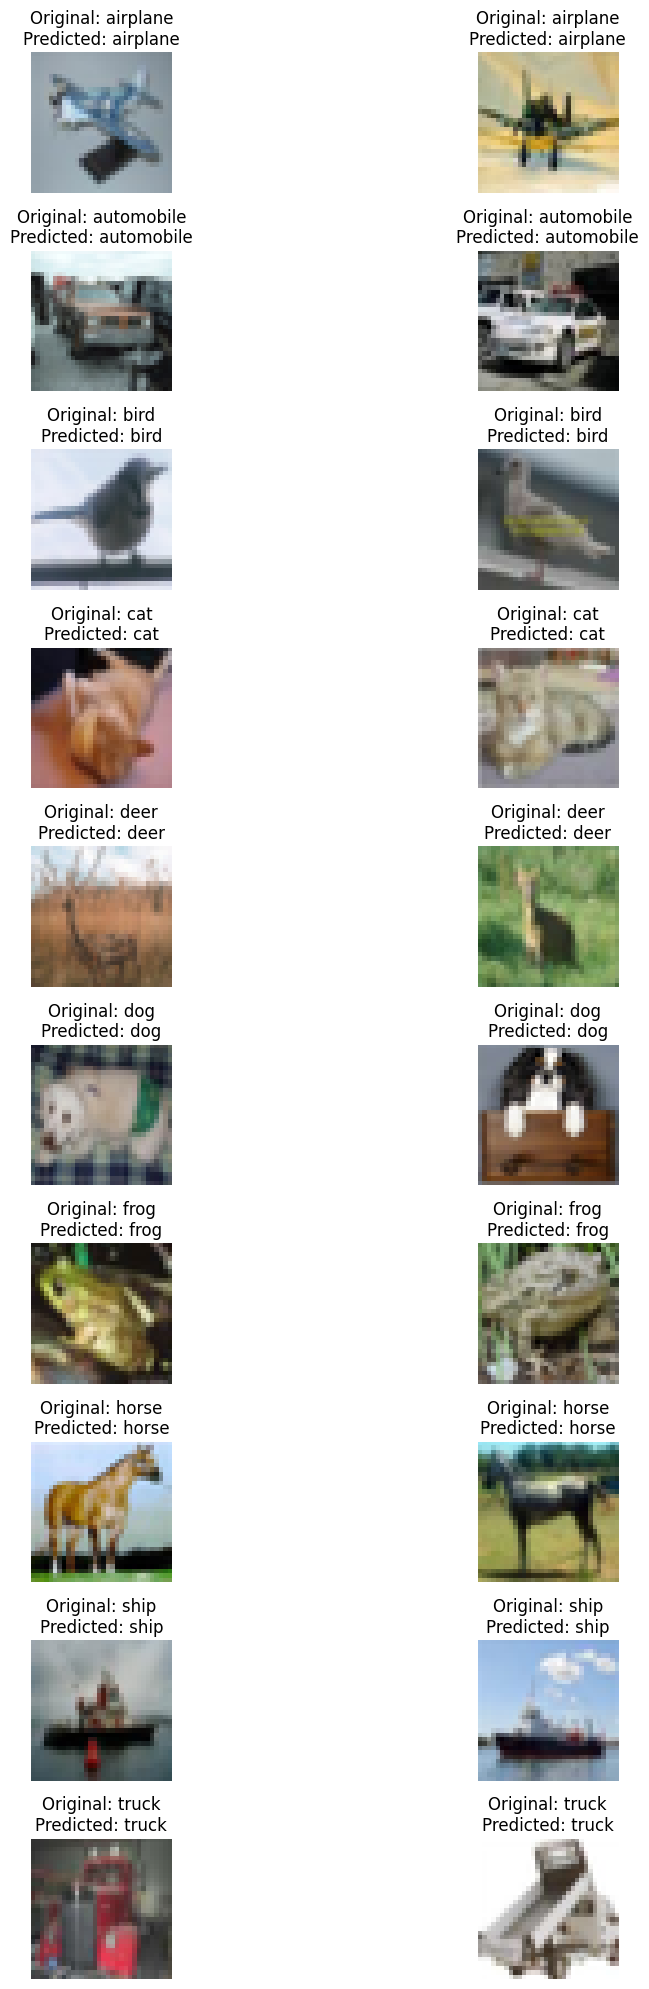

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images along with their labels
def plot_images(images, true_labels, pred_labels, class_names):
    num_classes = len(class_names)
    num_examples_per_class = 2
    fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(12, 2*num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'Original: {class_names[true_labels[idx]]}\nPredicted: {class_names[pred_labels[idx]]}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Show images with original and predicted labels
plot_images(X_test, y_test, y_pred_svm, class_names)


Misclassifications count per class:
Class 6: 70 misclassifications
Class 1: 64 misclassifications
Class 7: 117 misclassifications
Class 4: 127 misclassifications
Class 3: 198 misclassifications
Class 2: 156 misclassifications
Class 0: 75 misclassifications
Class 9: 77 misclassifications
Class 8: 43 misclassifications
Class 5: 154 misclassifications


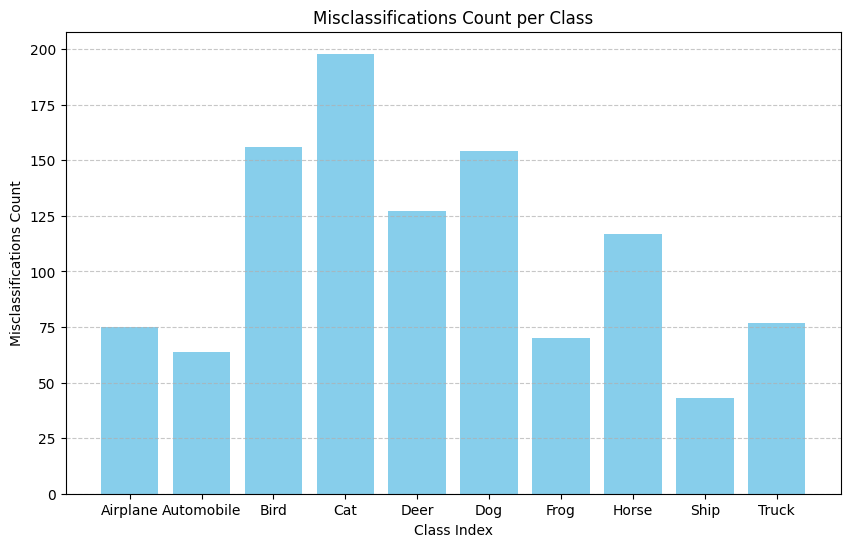

In [50]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_CNN)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


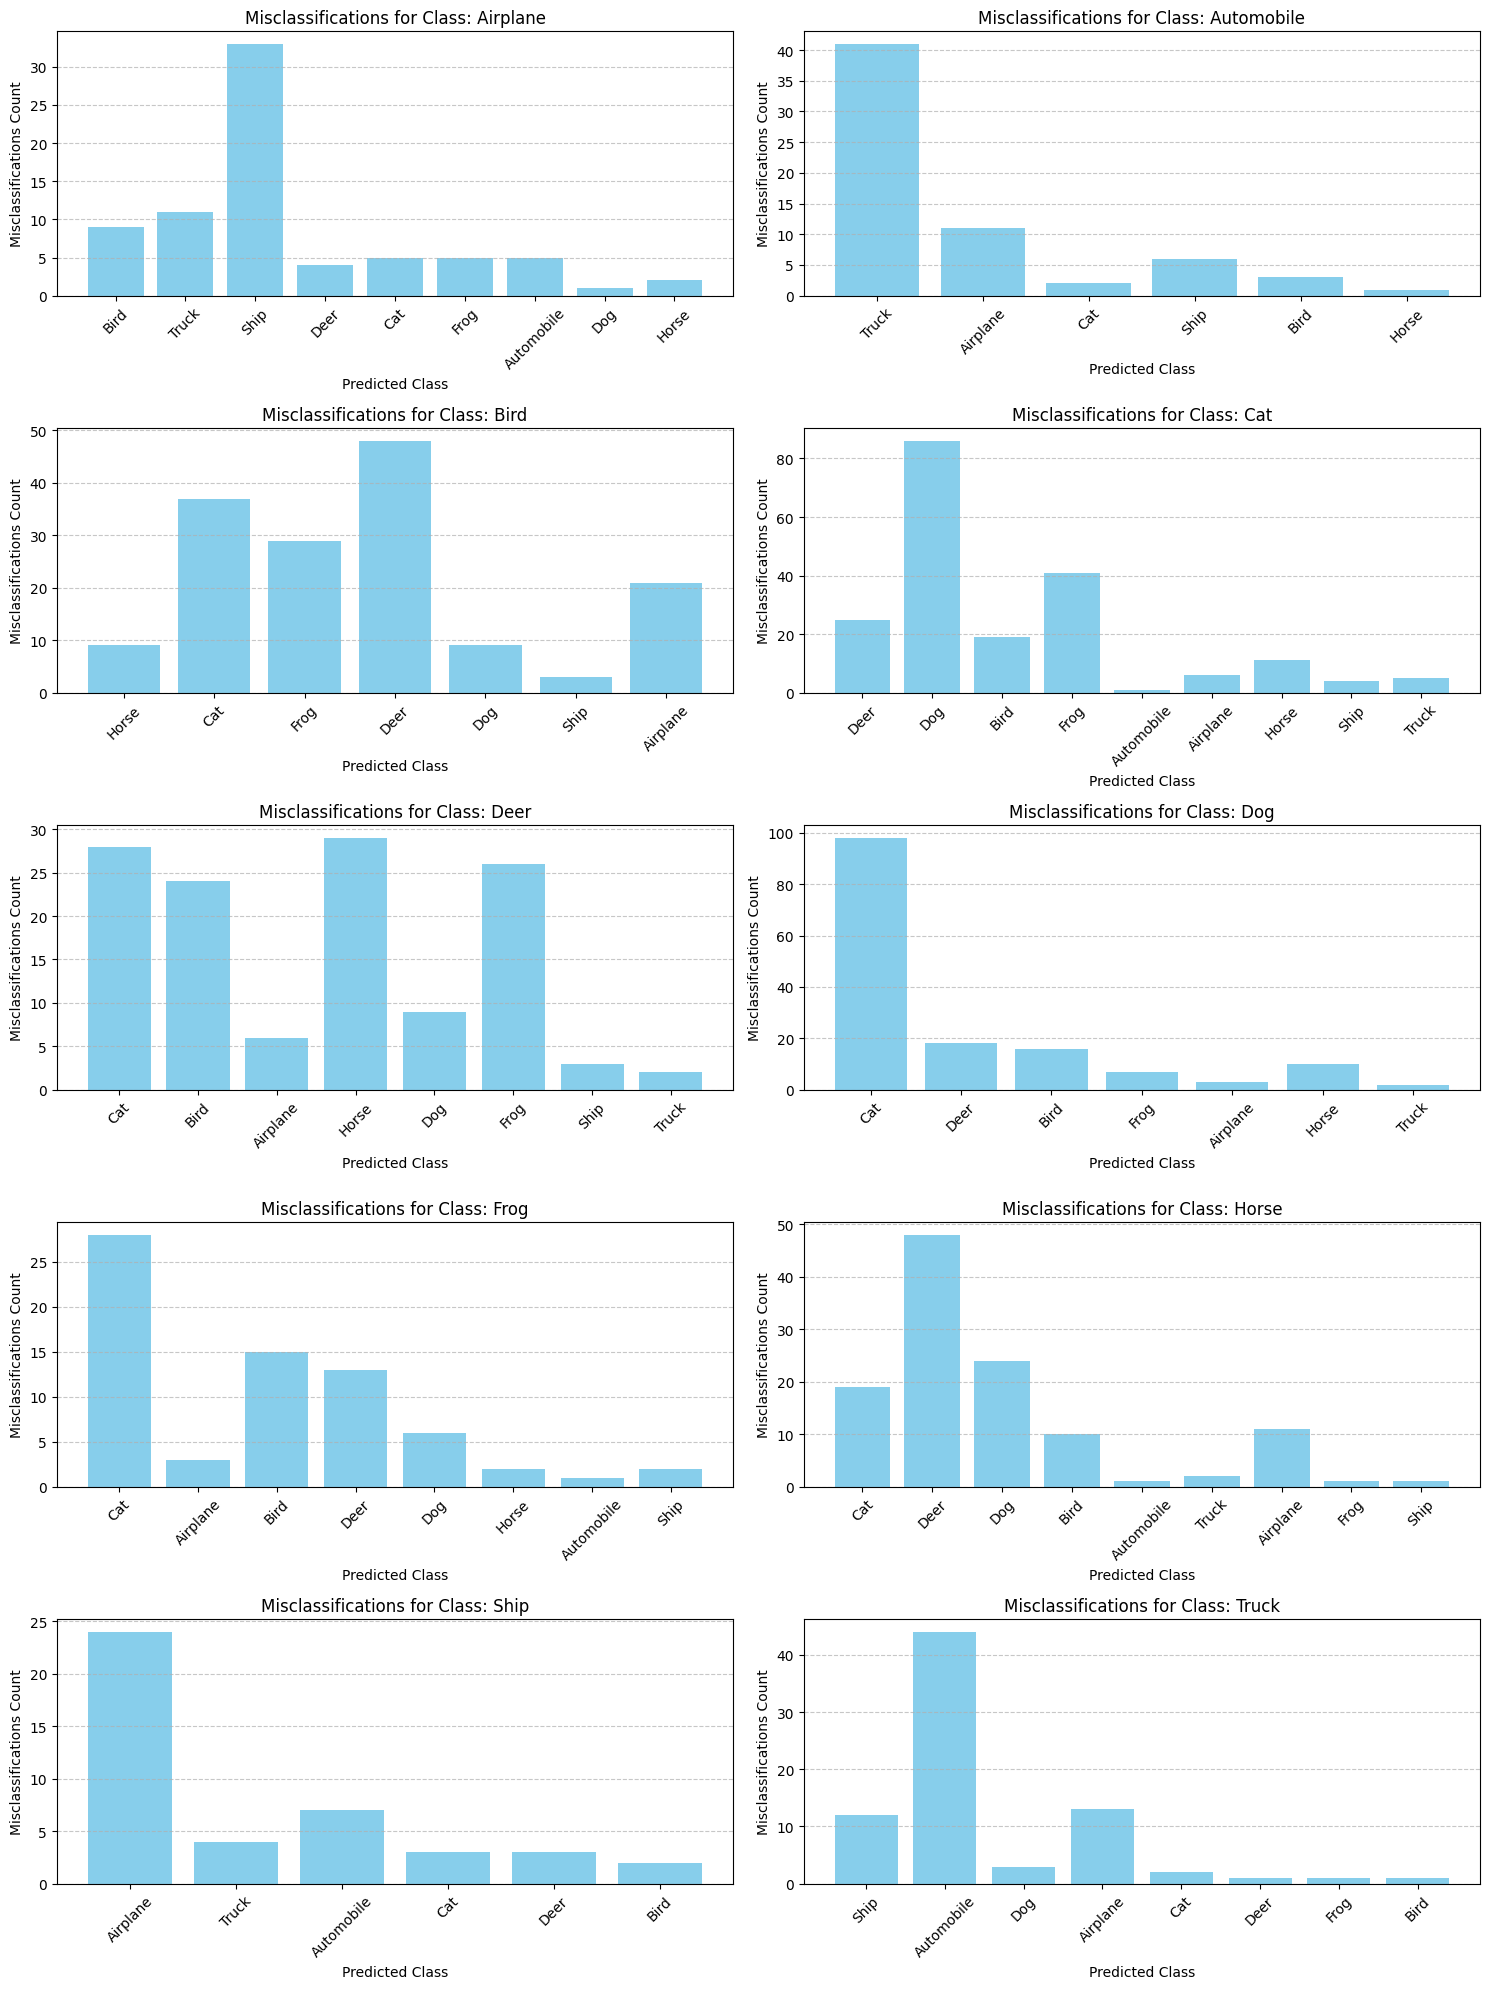

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### ANN

In [140]:
from tensorflow.keras.utils import to_categorical

# Convert target arrays to one-hot encoded format
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Define the model
simple_model = Sequential([
    Dense(8000, input_shape=(2048,), activation='relu'),
    Dense(3000, activation='relu'),
    Dense(3000, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
simple_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
simple_model_history = simple_model.fit(X_train_CNN, y_train_one_hot, batch_size=100, epochs=8, validation_data=(X_test_CNN, y_test_one_hot))


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.7302 - loss: 0.9548 - val_accuracy: 0.8477 - val_loss: 0.4403
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 151ms/step - accuracy: 0.8557 - loss: 0.4167 - val_accuracy: 0.8516 - val_loss: 0.4223
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.8740 - loss: 0.3662 - val_accuracy: 0.8559 - val_loss: 0.4135
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.8780 - loss: 0.3460 - val_accuracy: 0.8738 - val_loss: 0.3649
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 147ms/step - accuracy: 0.8871 - loss: 0.3226 - val_accuracy: 0.8610 - val_loss: 0.3947
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.8894 - loss: 0.3113 - val_accuracy: 0.8738 - val_loss: 0.3592
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 151ms/step - accuracy: 0.8973 - loss: 0.2924 - val_accuracy: 0.8725 - val_loss: 0.3811
Epoch 8/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 149ms/step - accuracy: 0.8982 - loss: 0.2874 - 

In [141]:
# Predict classes for the test set
y_pred = simple_model.predict(X_test_CNN)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to categorical labels
y_test_categorical = np.argmax(y_test_one_hot, axis=1)

# Calculate precision
precision = precision_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Calculate recall
recall = recall_score(y_test_categorical, y_pred_classes, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test_categorical, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision",precision)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Accuracy: 0.8787
Recall: 0.8787
F1 Score: 0.8779101668411659
Precision 0.8803099279240061


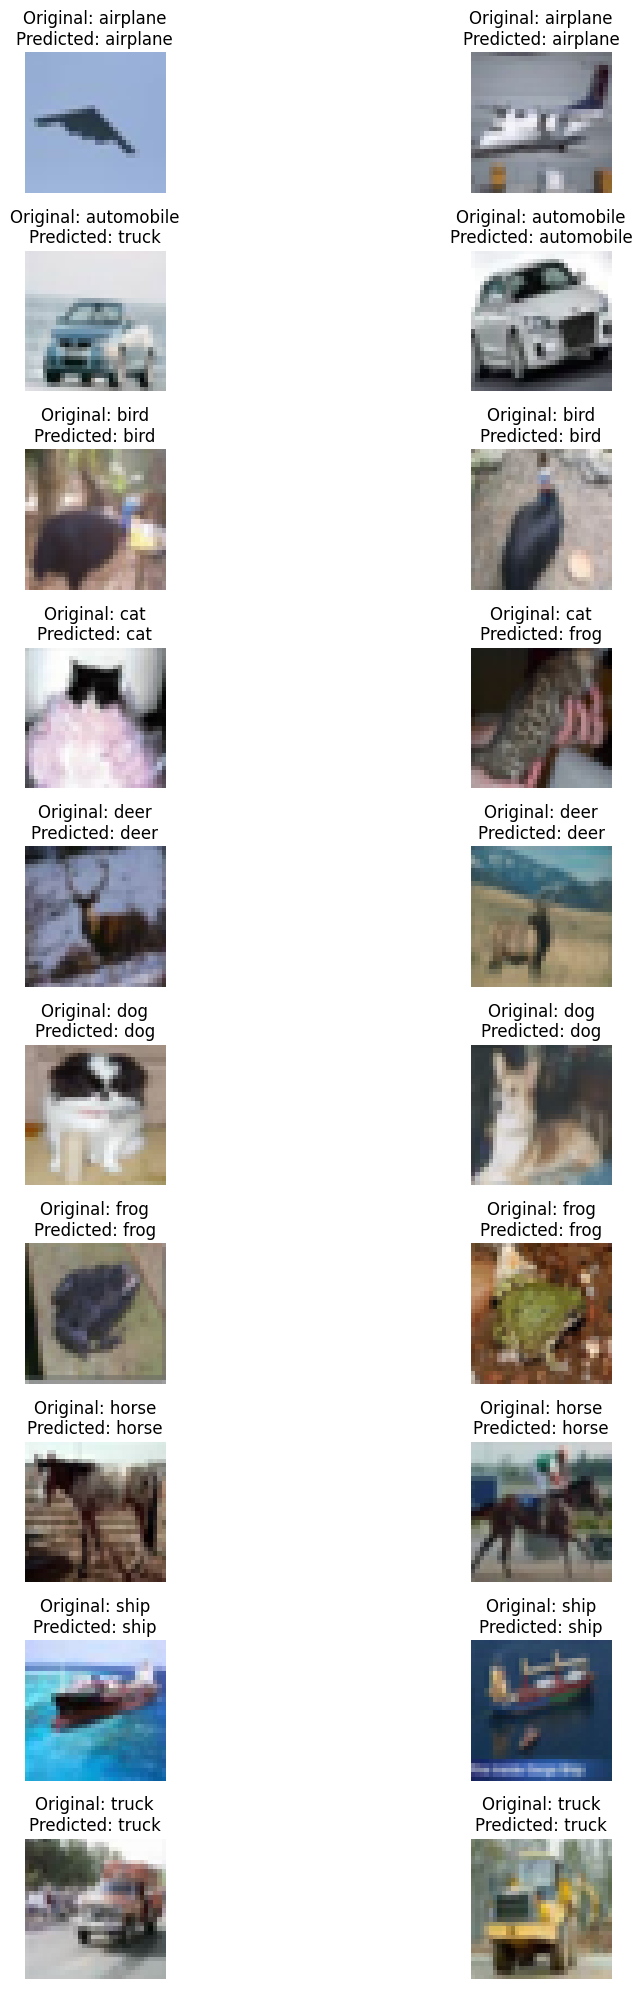

In [142]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images along with their labels
def plot_images(images, true_labels, pred_labels, class_names):
    num_classes = len(class_names)
    num_examples_per_class = 2
    fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(12, 2*num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'Original: {class_names[true_labels[idx]]}\nPredicted: {class_names[pred_labels[idx]]}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Define class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Show images with original and predicted labels
plot_images(X_test, y_test, y_pred_classes, class_names) 

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Misclassifications count per class:
Class Deer: 202 misclassifications
Class Bird: 175 misclassifications
Class Automobile: 115 misclassifications
Class Dog: 151 misclassifications
Class Horse: 61 misclassifications
Class Frog: 47 misclassifications
Class Cat: 253 misclassifications
Class Airplane: 113 misclassifications
Class Truck: 64 misclassifications
Class Ship: 32 misclassifications


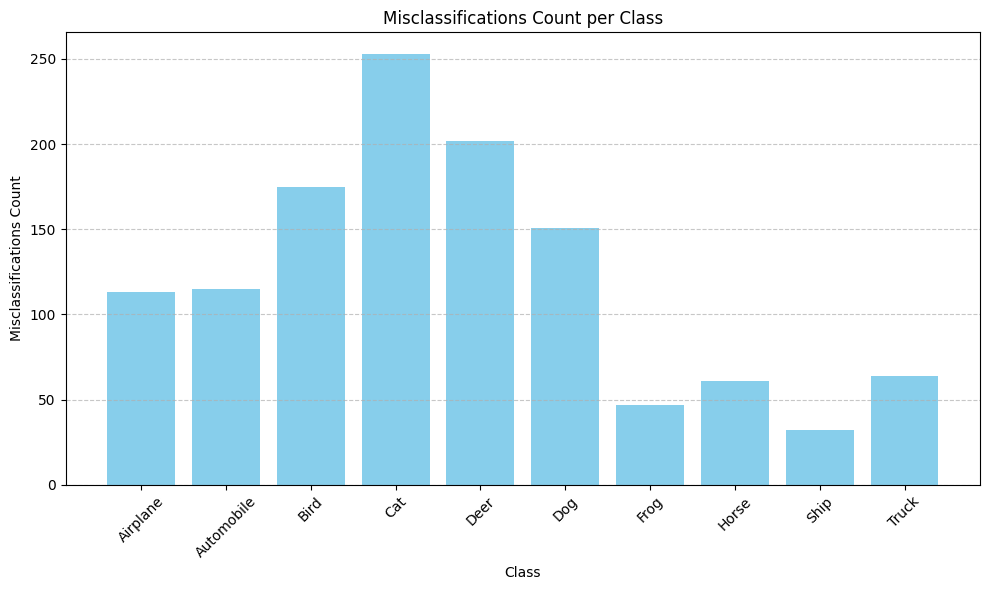

In [146]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_probs = simple_model.predict(X_test_CNN)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred_classes):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_names[class_index]}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class')
plt.ylabel('Misclassifications Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


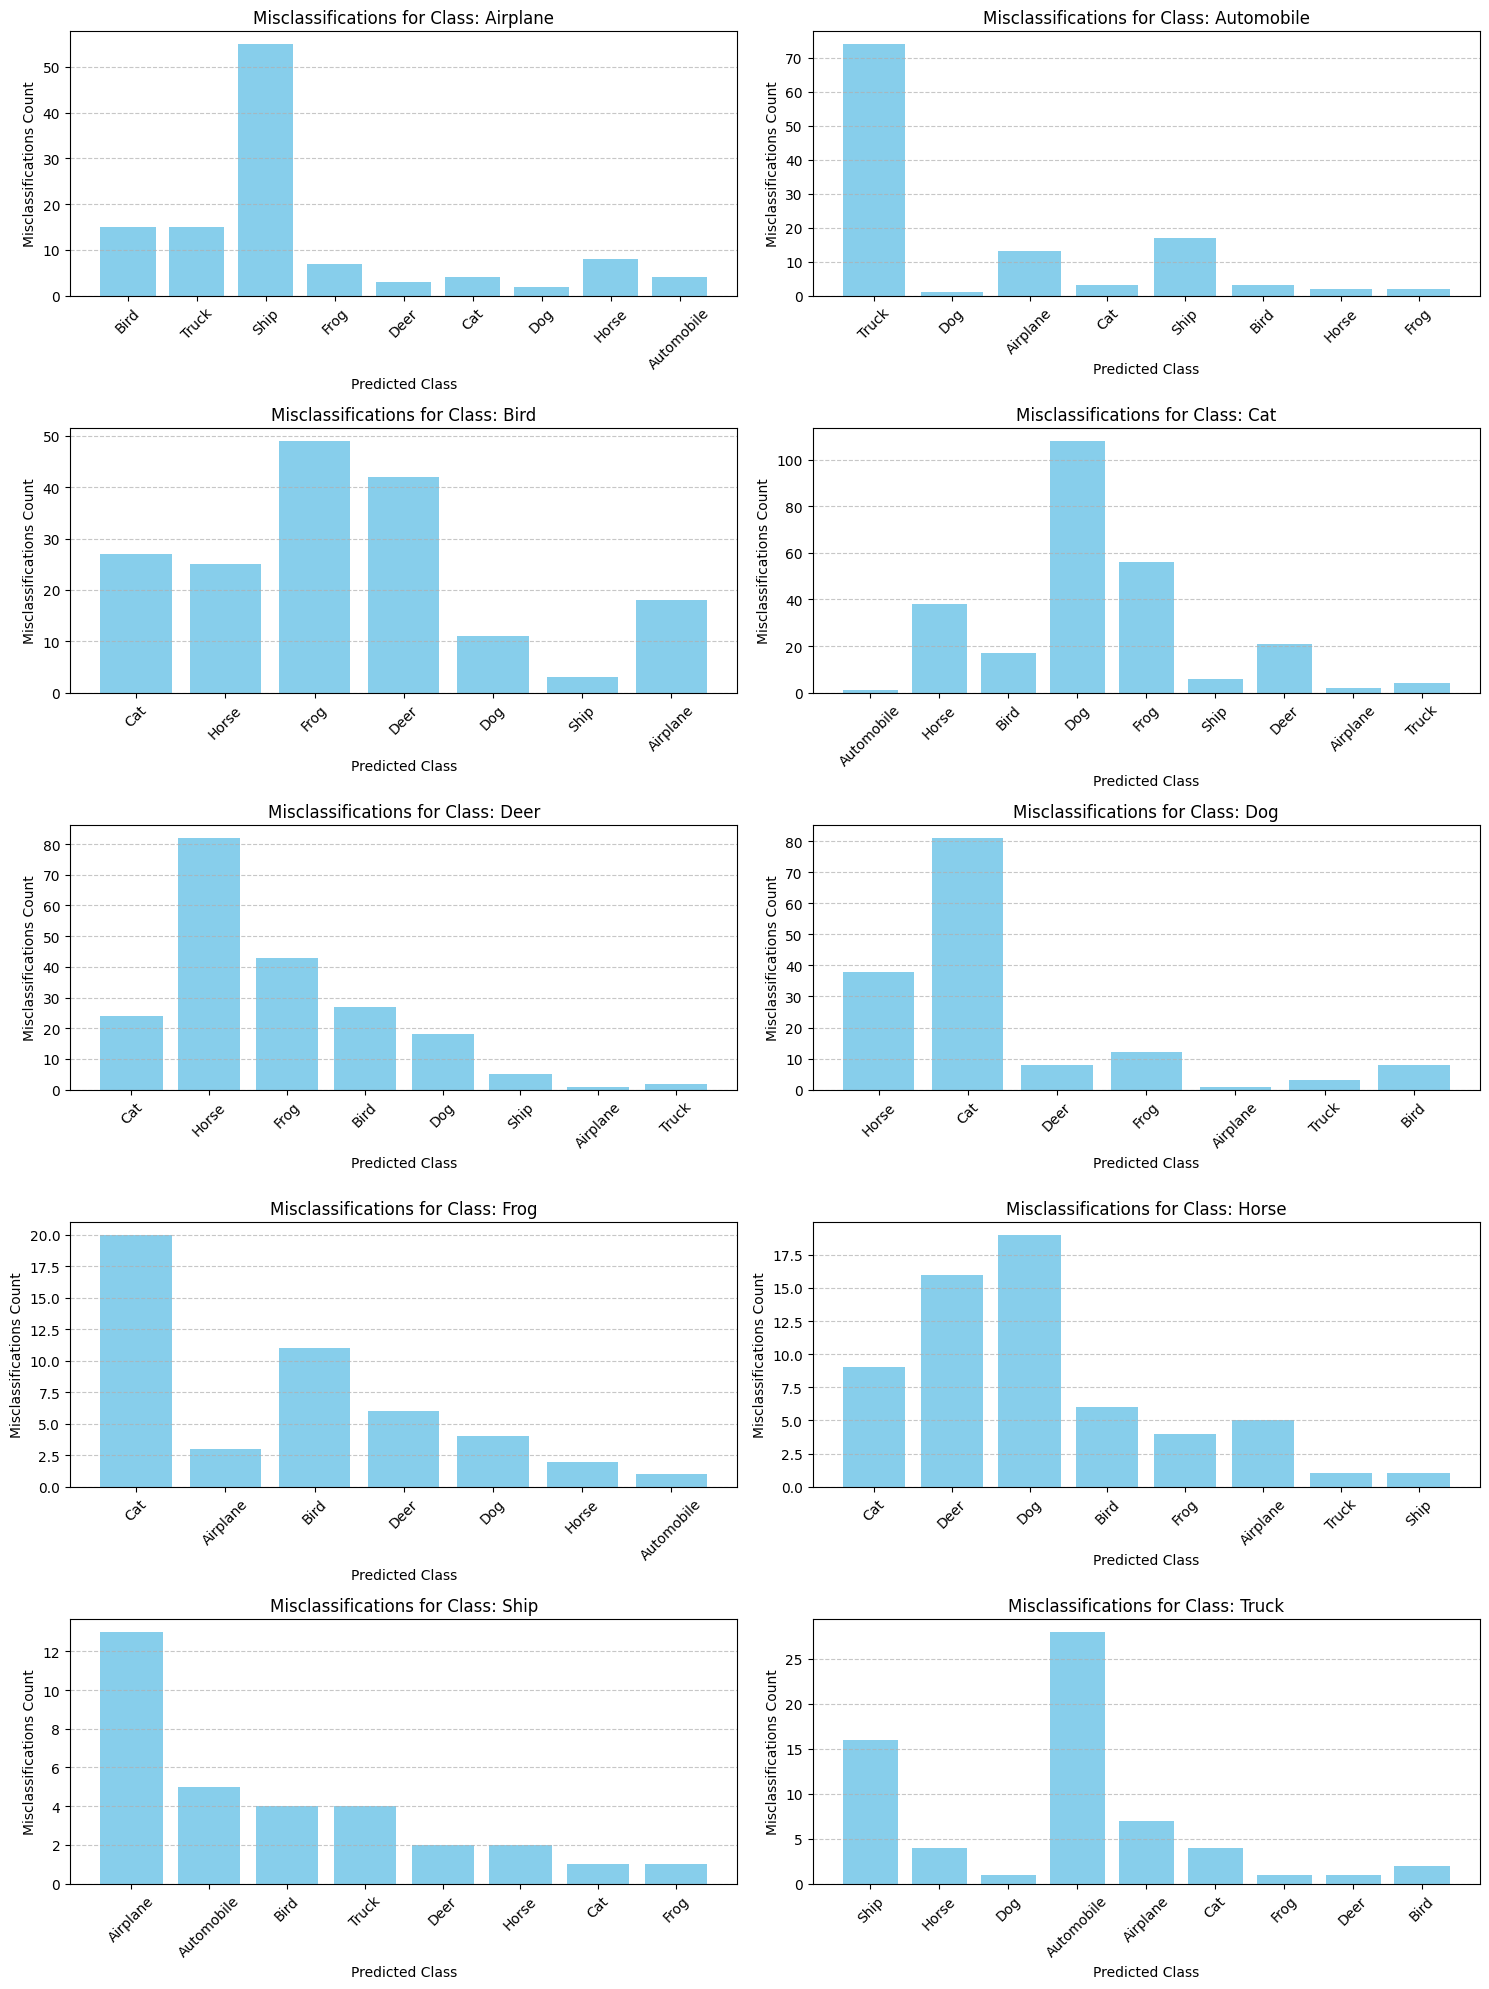

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Assuming y_test and y_pred are already defined
# Iterate through the test set and count misclassifications per class
for true_label, pred_labels in zip(y_test, y_pred):
    pred_label = np.argmax(pred_labels)
    if true_label != pred_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[pred_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
